# IoT Academy - Smart Manufacturing - Testbed 2 - Day 1

---

Within this notebook, you will be able to grasp how it feel to work as Data Scientist in the field of IoT. 

We will analyze the data that we collected from the AGV and we will develop simple statistical and machine learning approaches to perform autoregression of AGV's acceleration.


#### Jupyter

 - Remember that your code is executed dynamically, do not skip the execution of any cell before proceeding
 - Play with the code, do not be afraid to mess the code up. You can always download again the original version of the code
 - If you are using Colab, remember that the runtime will be disconnected after a period of inactivity
 - Remember to save your old results - maybe with a screenshot or duplicating the cells - if you want to compare your modification with old results
 - Ask for any kind of help!

# Activity 1: Development of the use-case and data visualization in real-time

During the first activity, you physically saw the testbed and visualized the data. Now it is time to get your hands on it!

# Activity 2: Data processing and visualization



## Data analysis and set up

In every data science task, the very first steps include to prepare the environment and the data for the statistical and machine learning models.

## Import libraries and define utility functions

Here we import useful libraries and code.

In [ ]:
import pandas as pd
import numpy as np
import sys
import random
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from math import floor
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import itertools
import warnings
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from scipy.signal import find_peaks
from sklearn.metrics import mean_squared_error, r2_score

#### Set up global variables

In [ ]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.rcParams['figure.figsize'] = [12, 9]
warnings.filterwarnings('ignore')

#### Import data

In [ ]:
!git clone https://github.com/Lostefra/IoT_Academy_2023.git

Cloning into 'IoT_Academy_2023'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 78 (delta 0), reused 0 (delta 0), pack-reused 73
Unpacking objects: 100% (78/78), 8.07 MiB | 2.81 MiB/s, done.


#### Paths

Here we define the location of the dataset.

In [ ]:
f_headers = r'IoT_Academy_2023/headers.txt'
f_acc = r'IoT_Academy_2023/test_data/dataset_acc.csv'

## Data import

We import the data. We employ `pandas.DataFrame` as data structure to handle the dataset. It basically consists in a tabular data structure.

In [ ]:
with open(f_headers) as f_headers:
    col_acc = f_headers.readline()[:-1].split(",")

In [ ]:
df = pd.read_csv(f_acc, names=col_acc)

#### Data inspection

In [ ]:
print(f'The dataset contains {len(df)} samples')
df.head()

The dataset contains 24360 samples


time_server     time_client     Gz      Ax      Ay
0 1656057475.1400 1655306285.8635 0.0840 12.3000 -7.7880
1 1656057475.2396 1655306285.9636 0.0687 10.6700 -8.2280
2 1656057475.3397 1655306286.0638 0.0382 11.1300 -7.5440
3 1656057475.4478 1655306286.1642 0.0611 12.4800 -8.0080
4 1656057475.5397 1655306286.2644 0.0916  9.6680 -7.5200

The `describe` method of the `DataFrame` class allow to get statistical insight over the time series.

In [ ]:
df.describe()

time_server     time_client         Gz         Ax         Ay
count      24360.0000      24360.0000 24360.0000 24360.0000 24360.0000
mean  1656058704.5148 1655307515.2388     0.8374    10.4749    -8.2018
std          711.1018        711.1037     1.6710     3.5786     3.6626
min   1656057475.1400 1655306285.8635    -4.7560   -22.1400   -31.2300
25%   1656058087.9953 1655306898.7202     0.0534     9.4480    -9.6190
50%   1656058702.7299 1655307513.4549     0.0992    10.6200    -8.2280
75%   1656059320.4446 1655308131.1704     1.7400    11.9600    -6.5920
max   1656059940.2991 1655308751.0276     4.8320    27.9800    16.0900

We will keep only the relevant columns for the autoregression task, namely the accelerations, and we also consider only those steps when AGV is moving (previously determined).

We also standardize the data, which is always a good practice.

In [ ]:
df1 = df[3300:13500]
df2 = df[15850:]
df = pd.concat([df1.reset_index(), df2.reset_index()]).reset_index()

relevant_columns = ["Ax", "Ay", "Gz"]
df = df[relevant_columns]

# initialize the StandardScaler object
scaler = StandardScaler()
# standardize the dataframe
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

Look back at data statistics to see the effects of standardization.

In [ ]:
df.describe()

Ax         Ay         Gz
count 18710.0000 18710.0000 18710.0000
mean     -0.0000     0.0000    -0.0000
std       1.0000     1.0000     1.0000
min      -8.0088    -5.5346    -3.1803
25%      -0.3717    -0.5333    -0.6112
50%       0.0253    -0.0005    -0.3359
75%       0.5422     0.5511     0.7024
max       4.3279     5.8380     2.0578

## Data trends visualization

We will now plot the acceleration of the AGV (possibly zoomed) over the time axis.

In [ ]:
def plot_all_signal(df, feature):
    plt.plot(df[feature], alpha=0.6)
    plt.legend([feature], loc='upper right')
    plt.show()

In [ ]:
def plot_all_signal_zoomed(df, feature):
    for i in range(0, len(df) - 1000, 1000):
        start = i
        end = i + 1000
        plt.plot(df[feature][start:end], alpha=0.6)
        plt.legend([feature], loc='upper right')
        plt.show()

#### Ax values

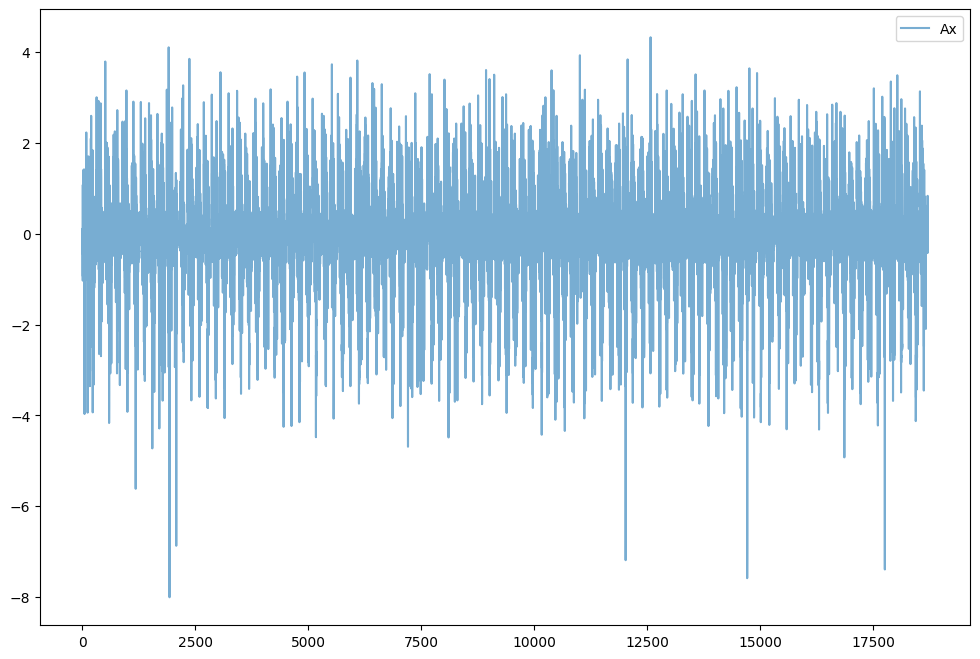

In [ ]:
plot_all_signal(df, "Ax")

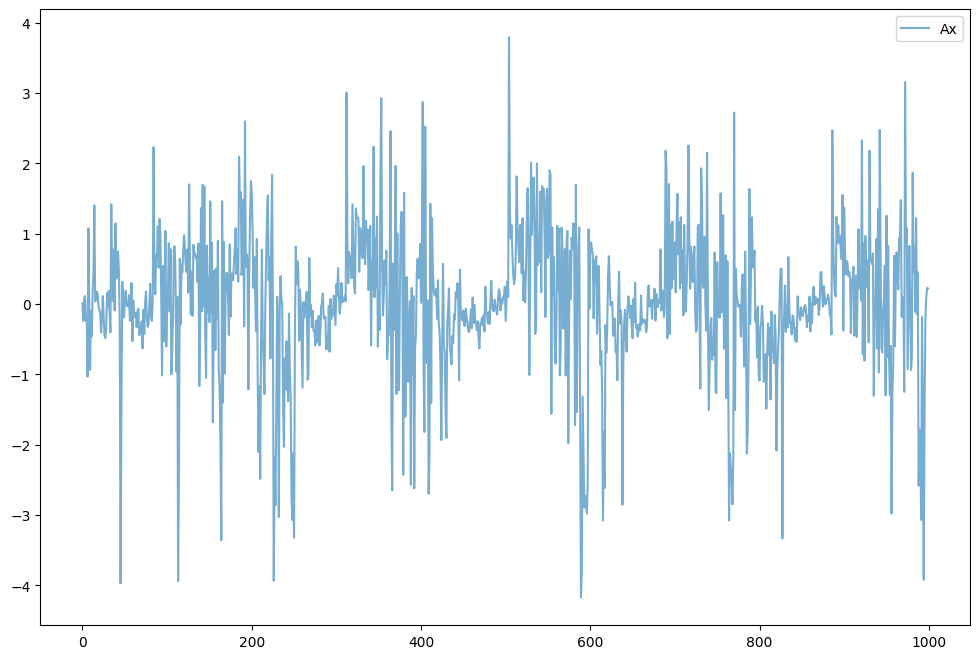

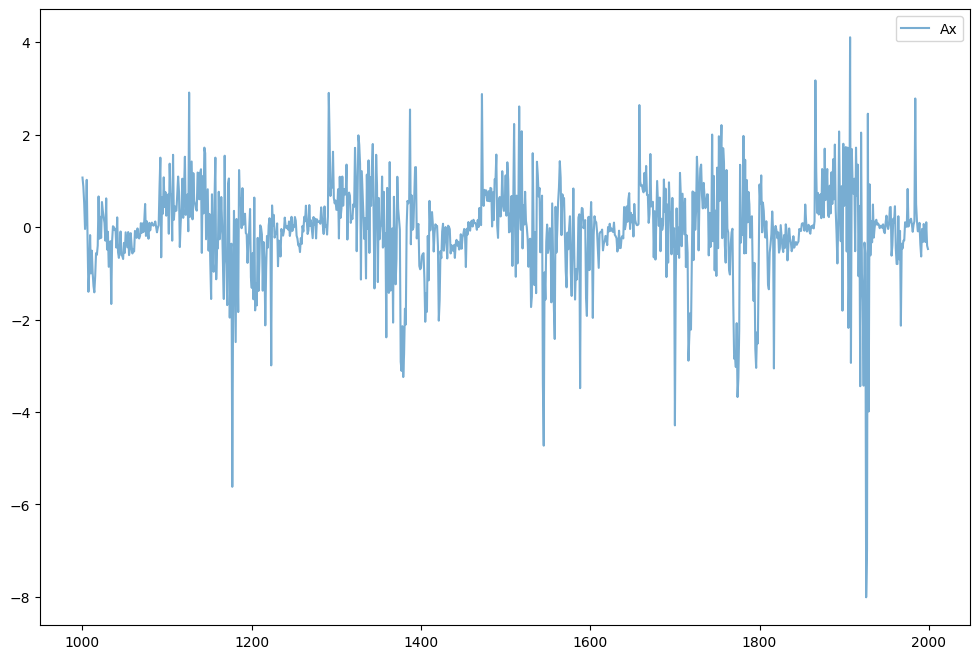

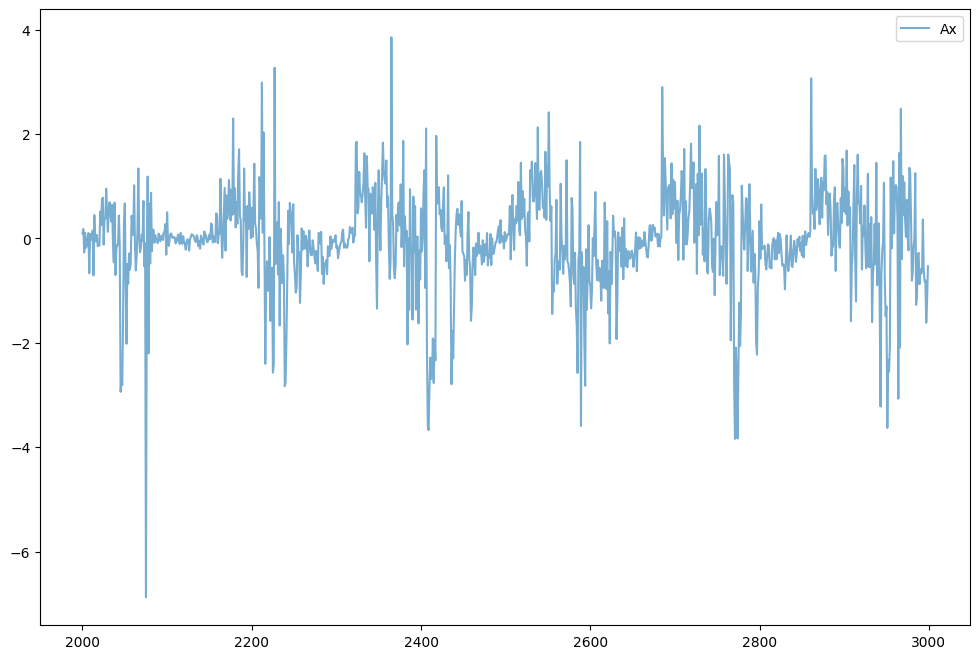

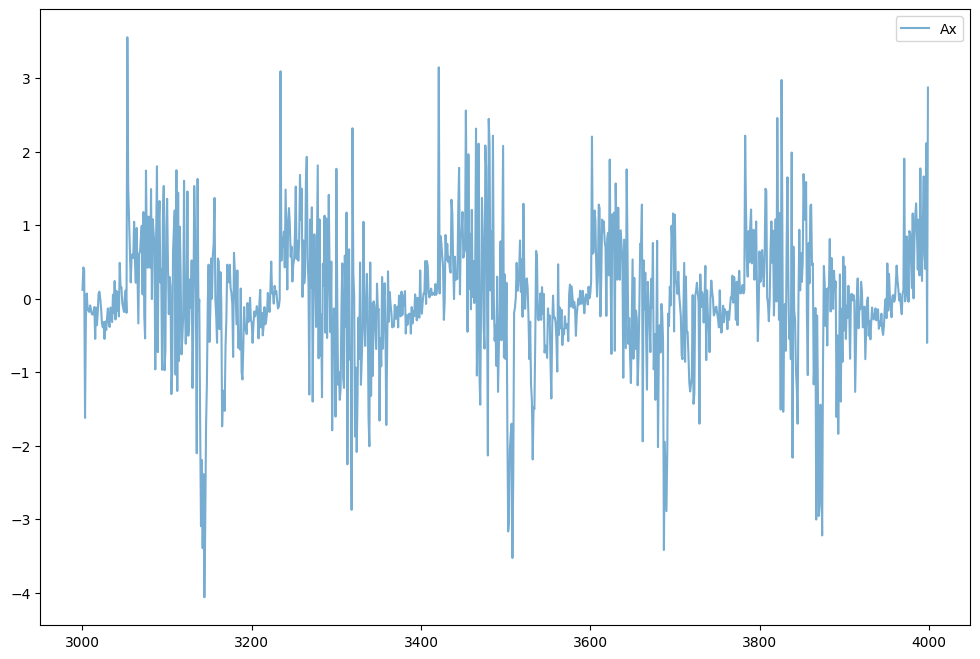

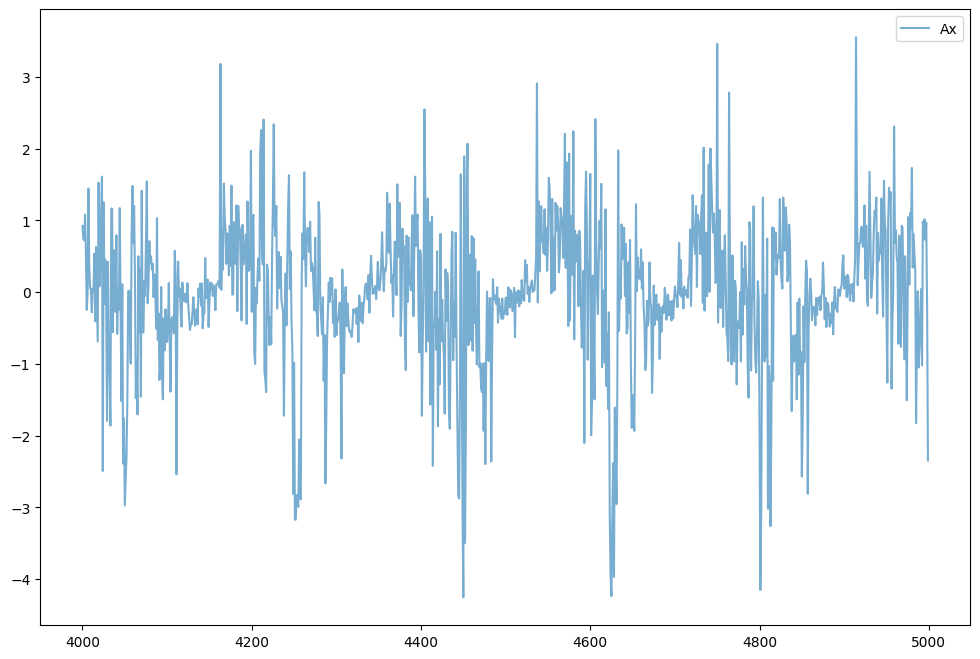

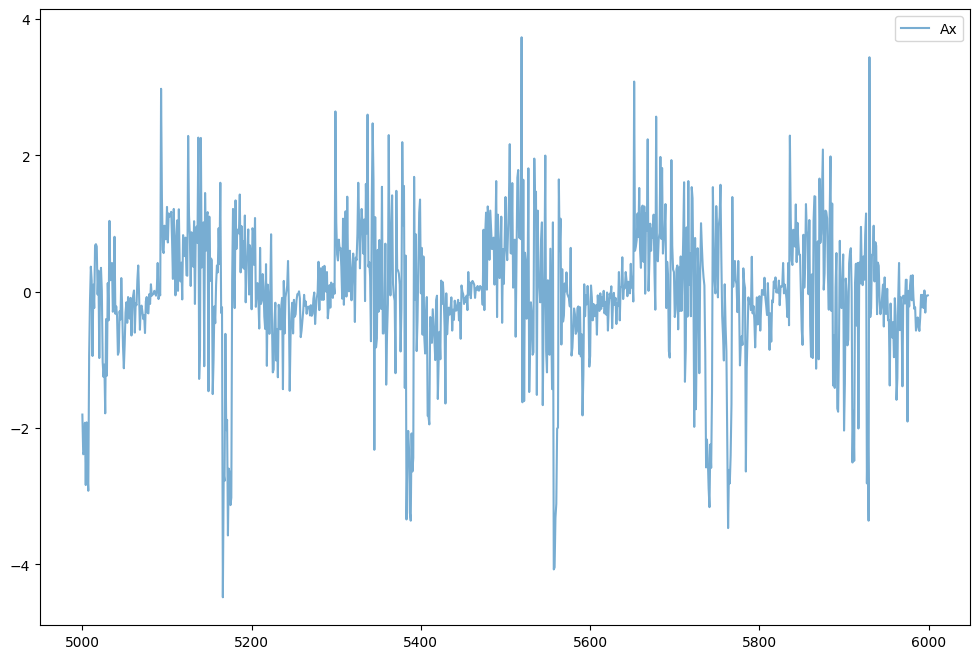

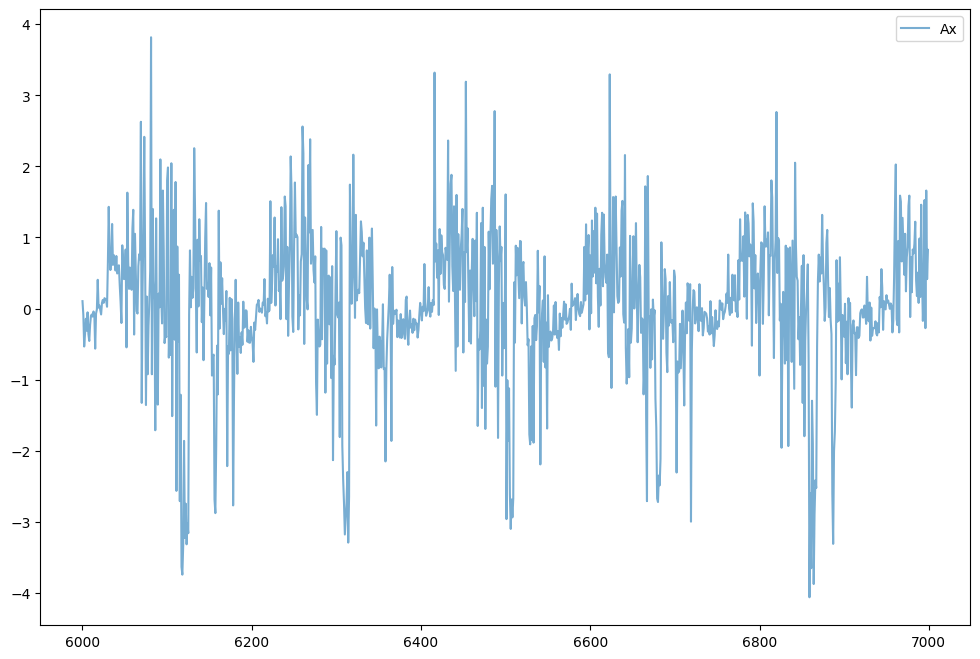

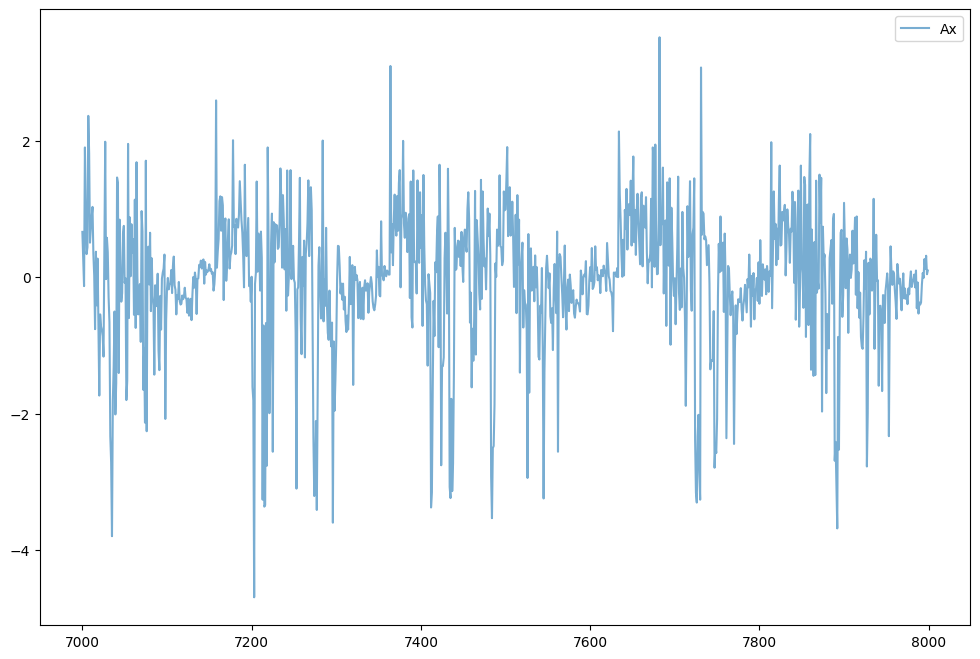

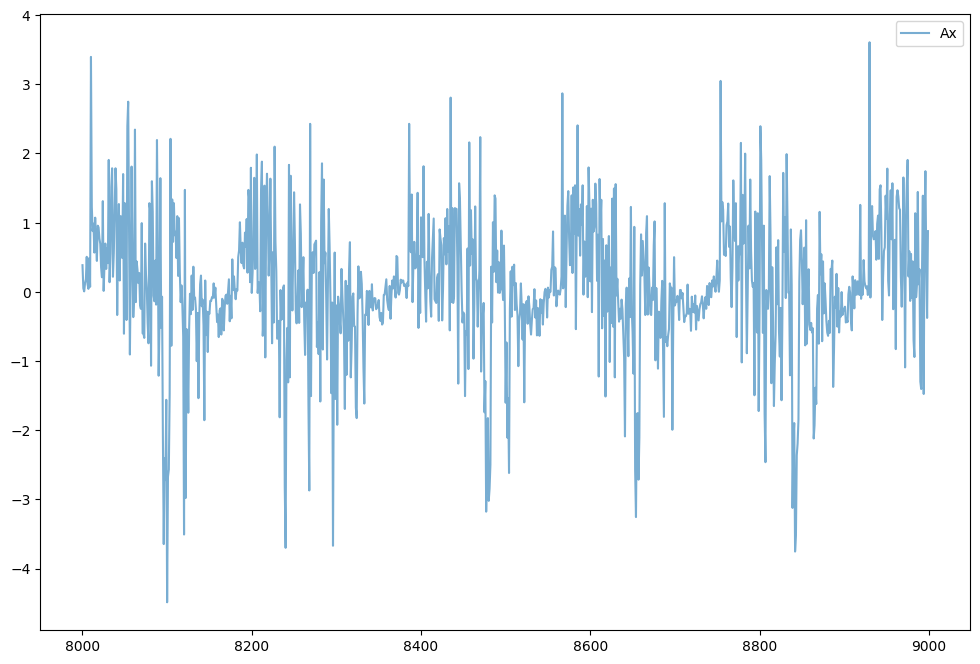

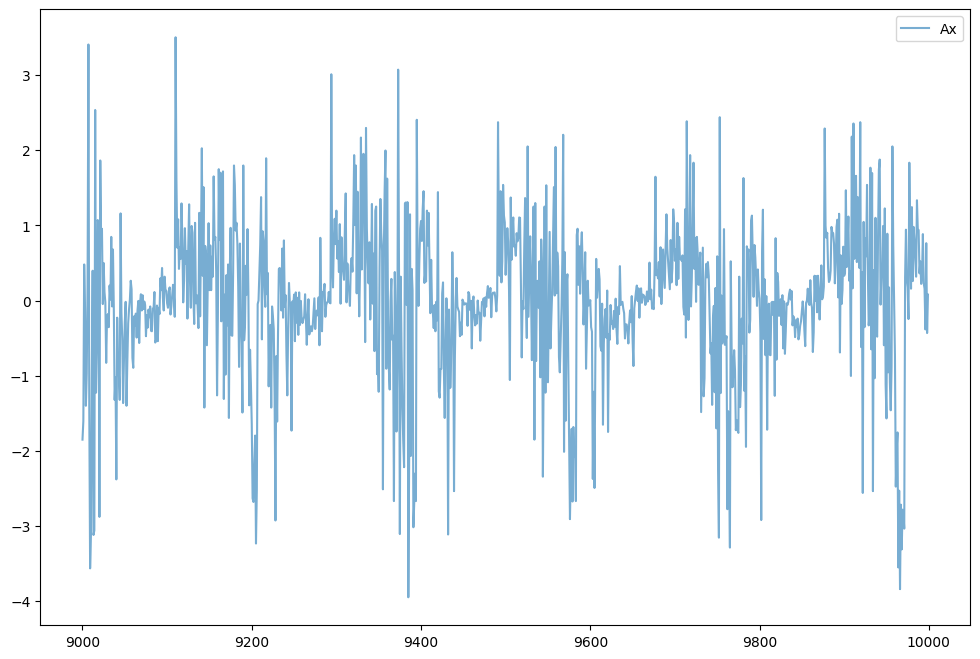

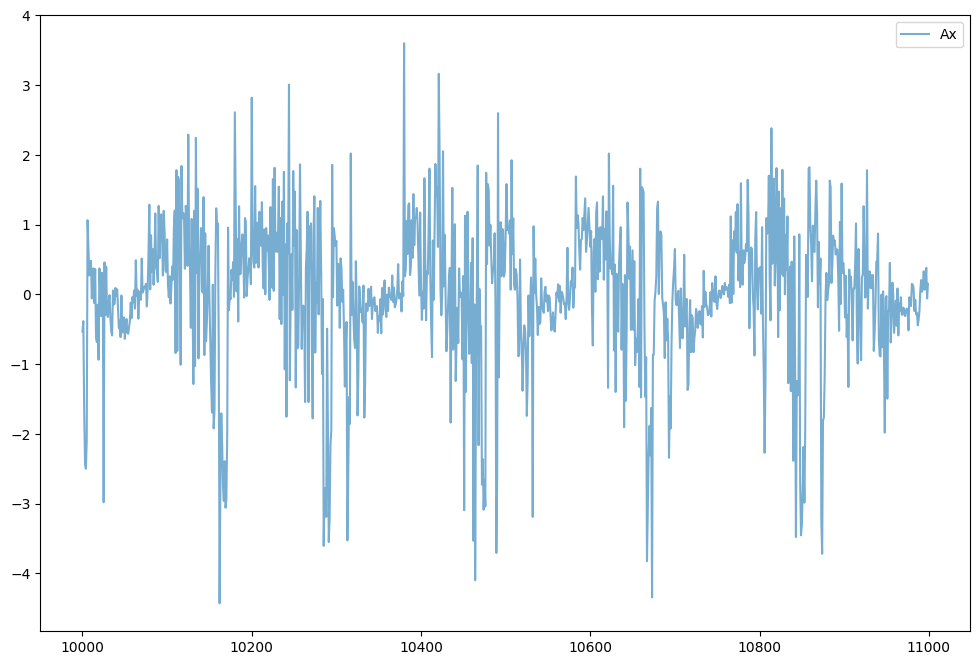

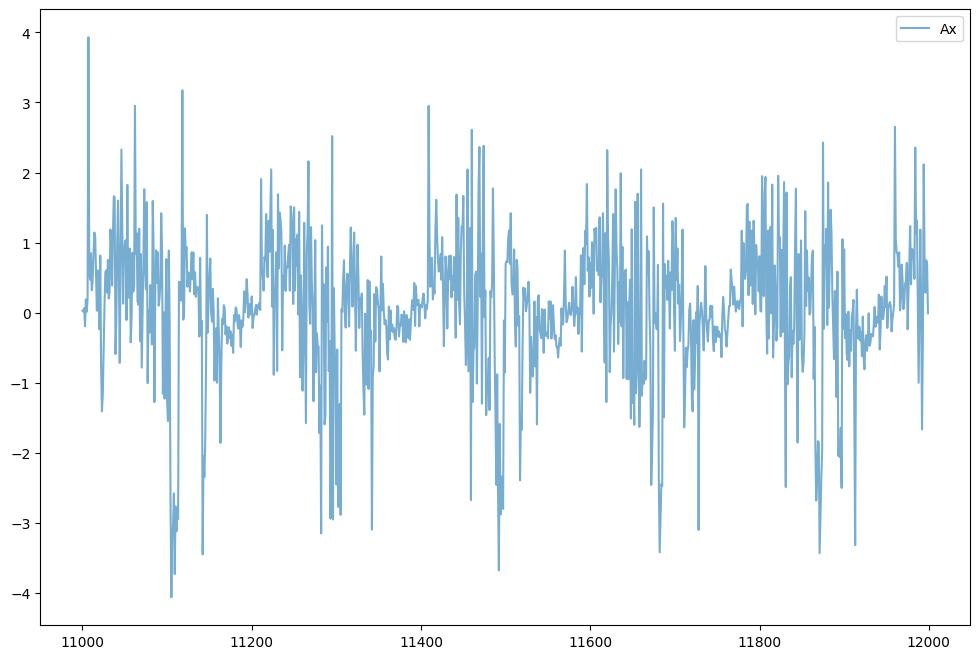

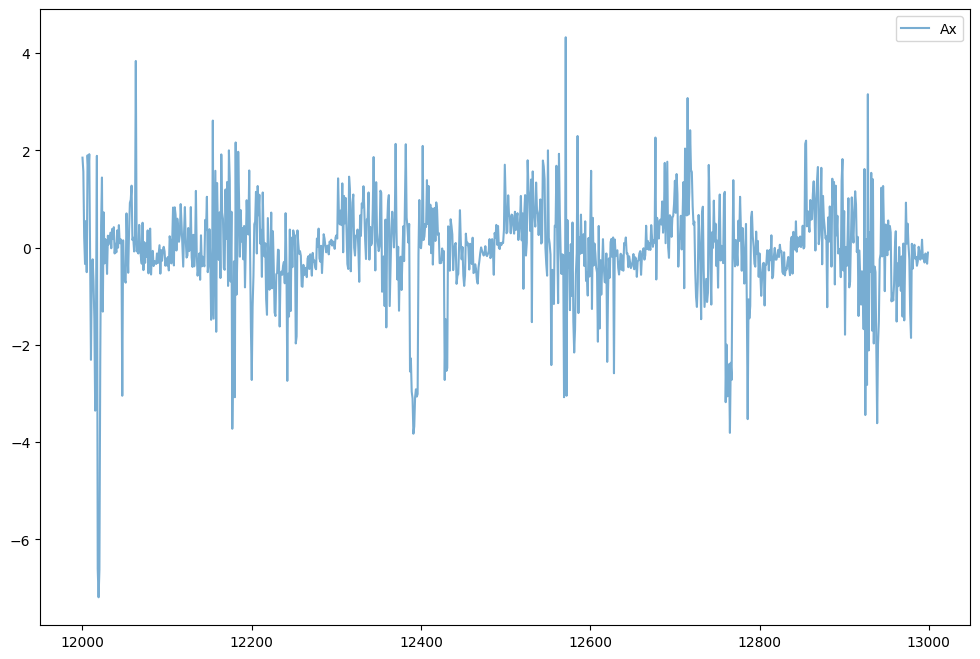

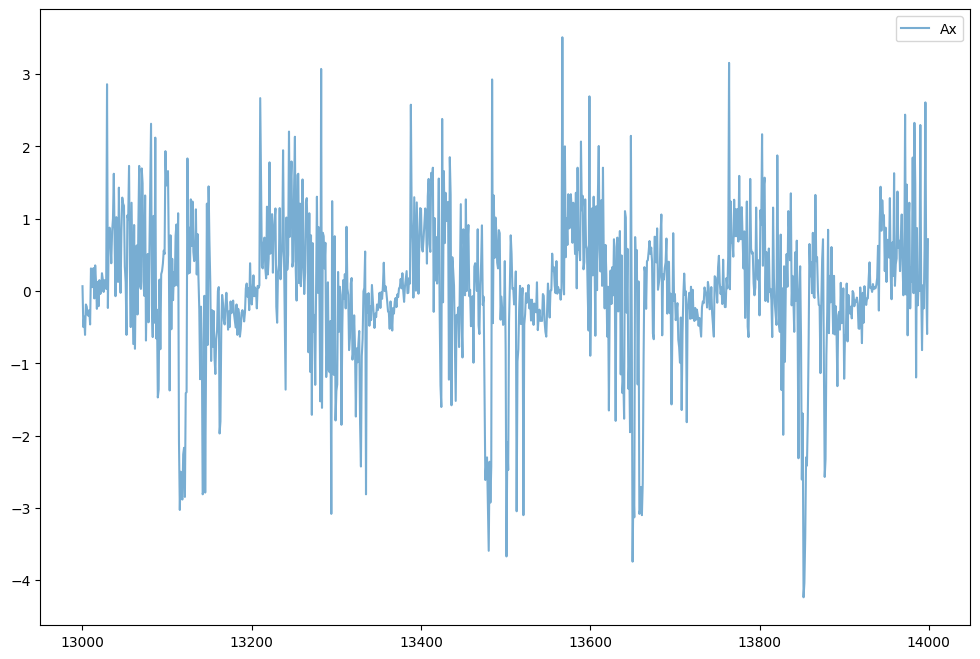

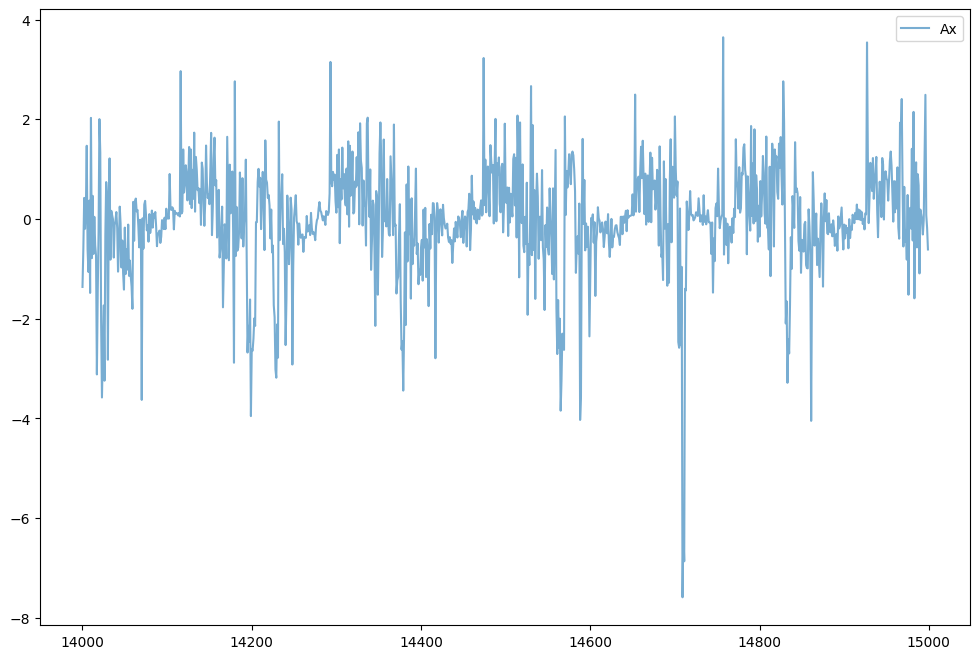

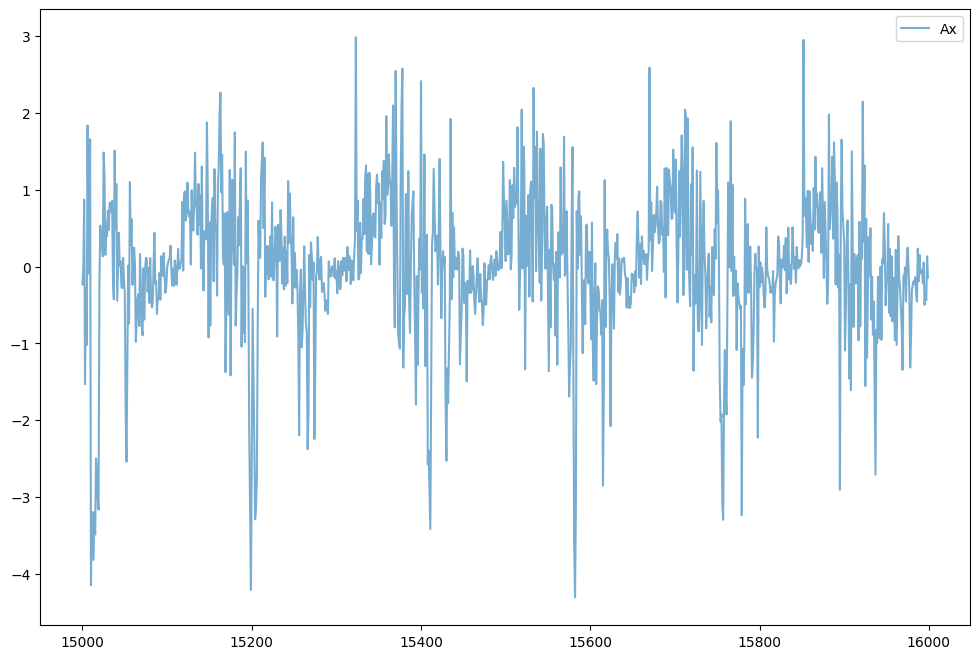

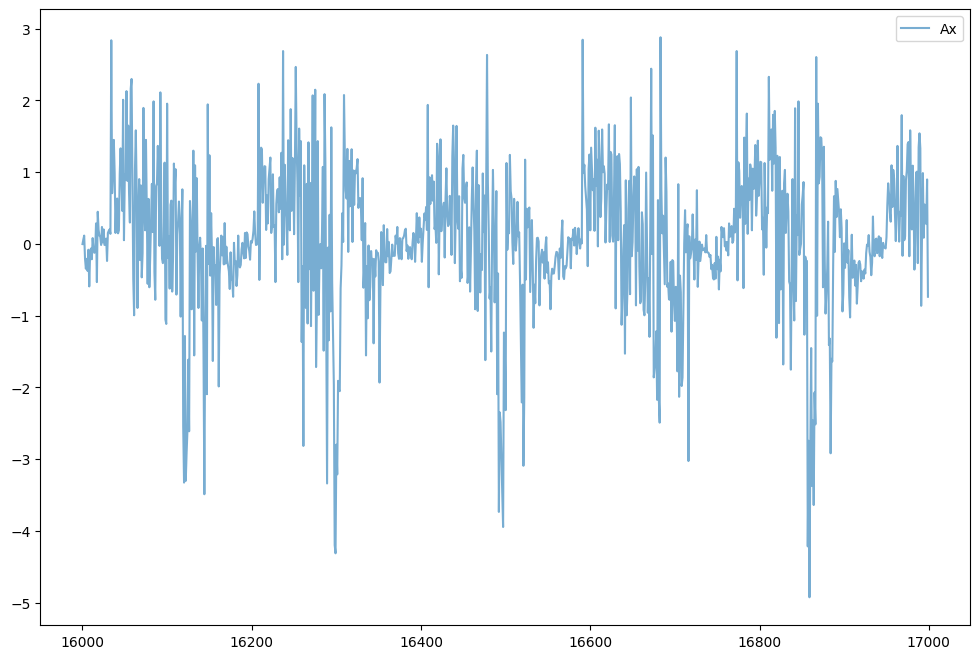

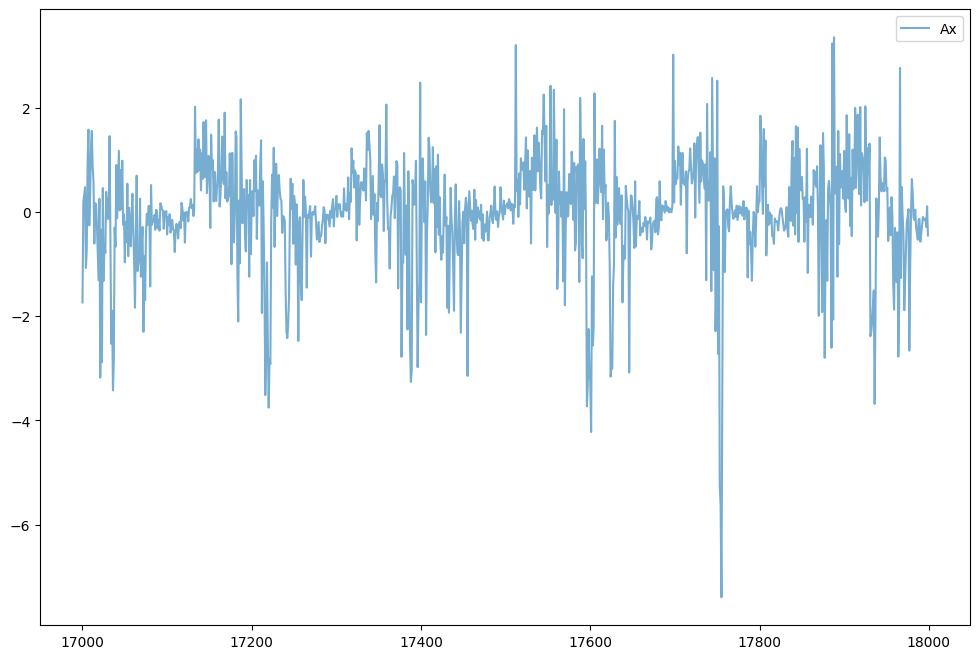

In [ ]:
plot_all_signal_zoomed(df, "Ax")

# Activity 3: Statistical models fitting and evaluation for autoregression

#### Investigating whether there is a trend

The **Augmented Dickey-Fuller (ADF) test** is a statistical test used to determine if a time series is stationary or not. The ADF test is a type of unit root test, which tests whether a time series has a unit root (i.e., a root of 1) in its autoregressive equation. A time series that has a unit root is non-stationary and has a trend.

Here is how to interpret the results of the ADF test:

* **Test Statistic**: This is the value of the ADF test statistic. The more negative this value is, the stronger the evidence against the null hypothesis (which is that the time series has a unit root) and in favor of the alternative hypothesis (which is that the time series is stationary).

* **p-value**: This is the probability of obtaining a test statistic as extreme as the one observed, assuming the null hypothesis is true. A p-value less than the significance level (usually 0.05) indicates that the null hypothesis should be rejected.

* **#Lags Used**: This is the number of lags used in the regression equation.

* **Number of Observations Used**: This is the number of observations used in the regression equation.

* **Critical Values**: These are the values used to determine whether the test statistic is significant or not. The critical values depend on the significance level and the number of observations used. In this case, there are three critical values: the 1% critical value, the 5% critical value, and the 10% critical value. If the absolute value of the test statistic is greater than the critical value, then the null hypothesis is rejected.

We can conclude that the time series is stationary if the test statistic is highly negative and the p-value is very small (less than 0.05).

More details here: [link](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html).

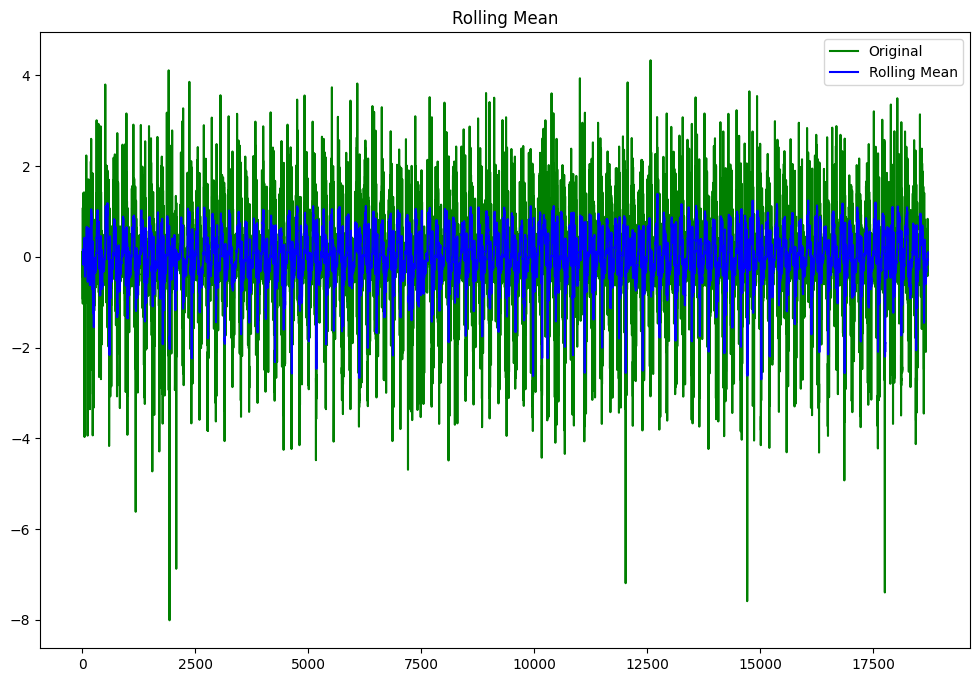

Augmented Dickey-Fuller test:


Test Statistic                  -18.5946
p-value                           0.0000
#Lags Used                       44.0000
Number of Observations Used   18665.0000
Critical Value (1%)              -3.4307
Critical Value (5%)              -2.8617
Critical Value (10%)             -2.5669
dtype: float64

In [ ]:
def stationarity_check(ts):
    # Determing rolling statistics
    roll_mean = ts.rolling(12).mean()
    # Plot rolling statistics:
    plt.plot(ts, color='green', label='Original')
    plt.plot(roll_mean, color='blue', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()
    # Perform Augmented Dickey-Fuller test:
    df_test = adfuller(ts)
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    return df_output

df_output_adf = stationarity_check(df["Ax"])
print('Augmented Dickey-Fuller test:')
df_output_adf

## Autocorrelation function (ACF) and Partial Autocorrelation function (PACF)

The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) are statistical tools used to analyze time series data. 

The ACF measures the correlation between a time series and its lagged values, while the PACF measures the direct correlation between a time series and its lagged values. 

Both the ACF and PACF are useful in time series analysis because they provide information about the underlying structure of the time series data, which can aid in forecasting future values and identifying trends and patterns.

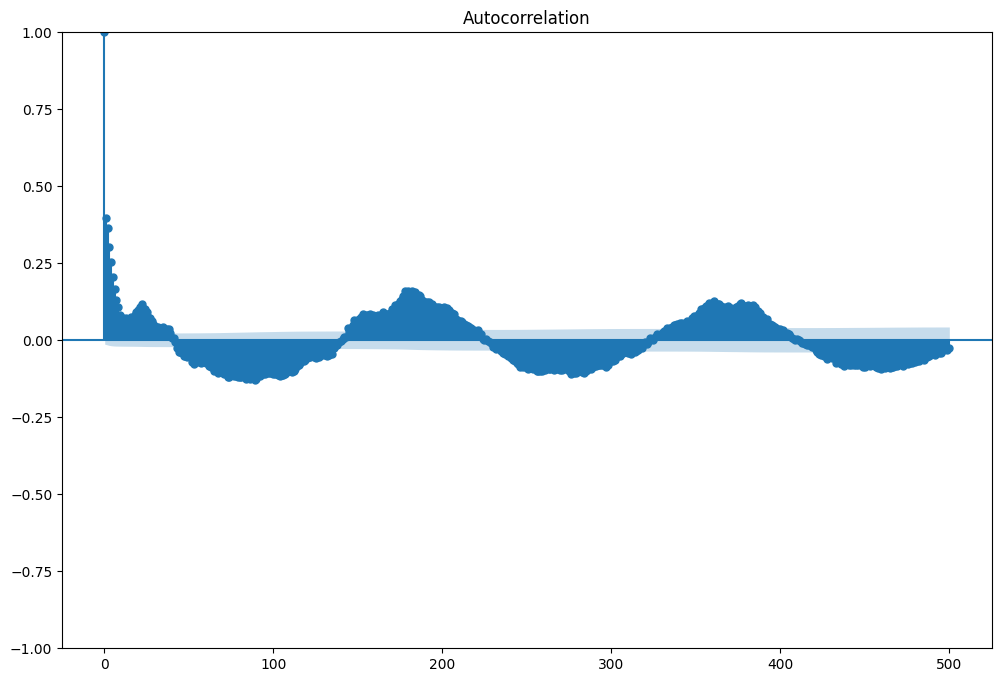

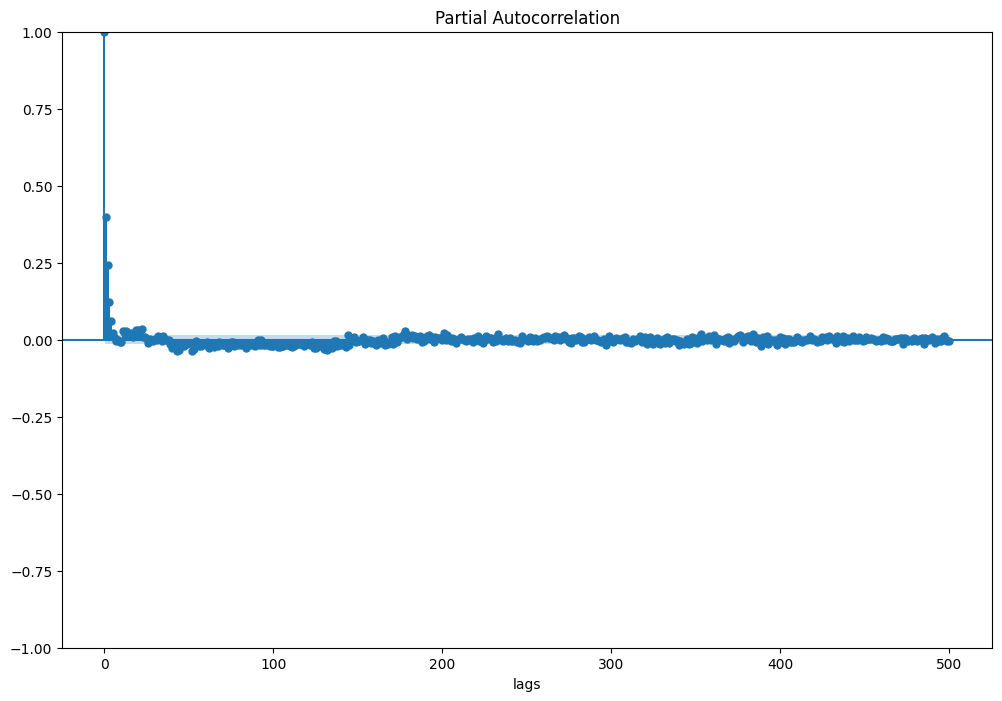

In [ ]:
plot_acf(df["Ax"], lags=500)
plot_pacf(df["Ax"], lags=500)
plt.xlabel('lags')
plt.show()

## Tackling seasonality

Since seasonality is evident in the ACF, we will apply seasonal differencing to remove it.

The seasonal period can be identified by looking at peaks in the ACF plot.

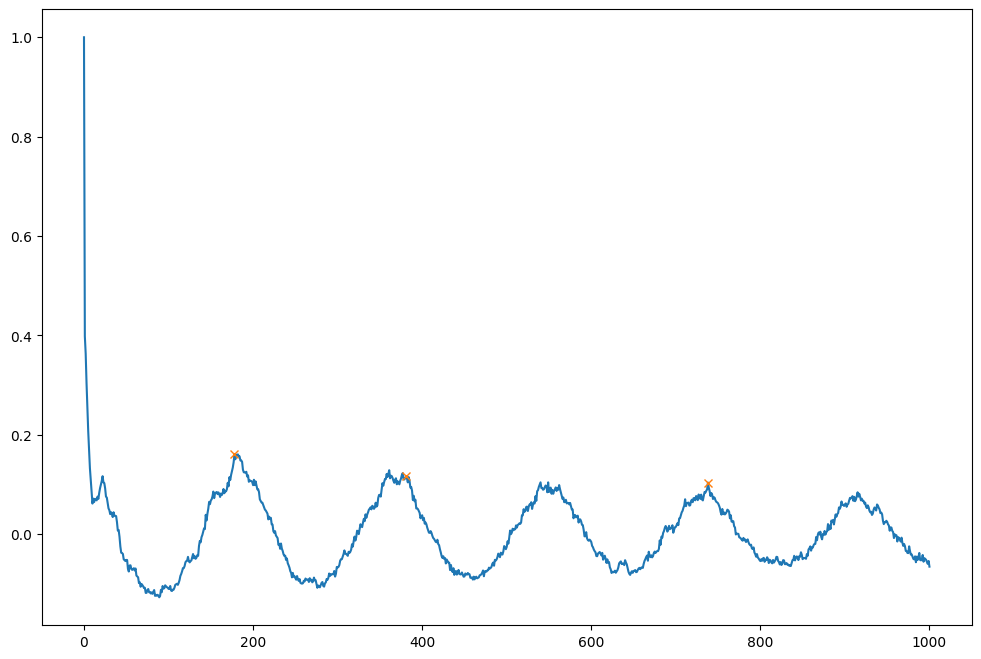

The seasonal period is equal to: 178 data samples.


In [ ]:
# Calculate the ACF values for the "Ax" column
acf_vals = acf(df["Ax"], nlags=1000)

# Set minimum peak height and distance
min_peak_height = 0.1  # adjust as needed
min_peak_distance = 200  # adjust as needed

# Find the local maxima of the ACF function with the specified parameters
peaks, _ = find_peaks(acf_vals, height=min_peak_height, distance=min_peak_distance)

# Plot the ACF function with the peak(s) highlighted
plt.plot(range(len(acf_vals)), acf_vals)
plt.plot(peaks, acf_vals[peaks], "x")
plt.show()

# Print the lags at which the peaks occur
print("The seasonal period is equal to:", peaks[0], "data samples.")

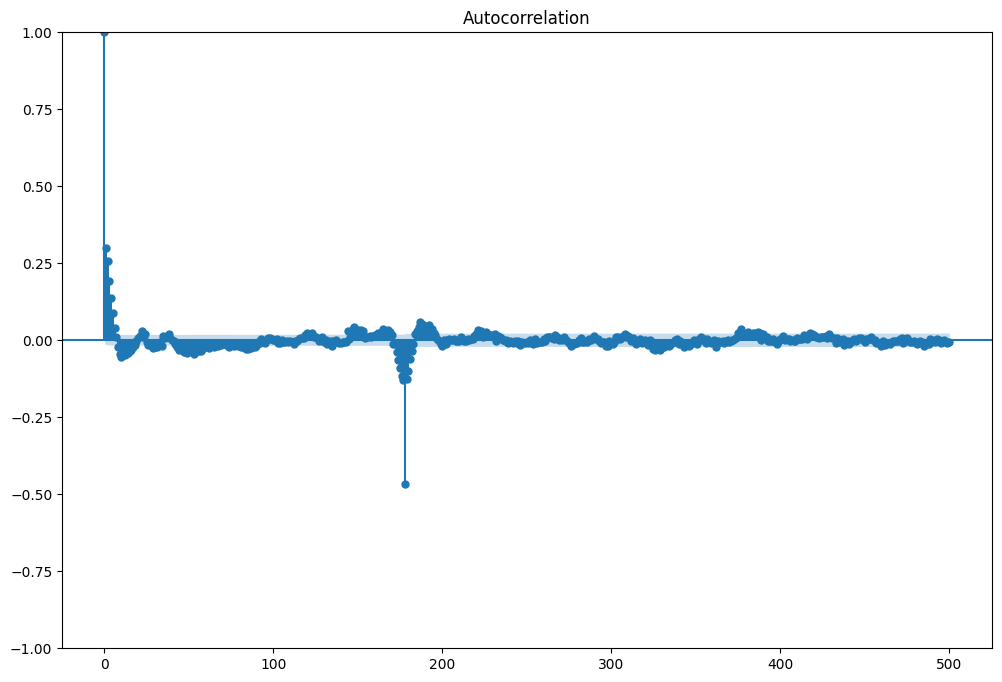

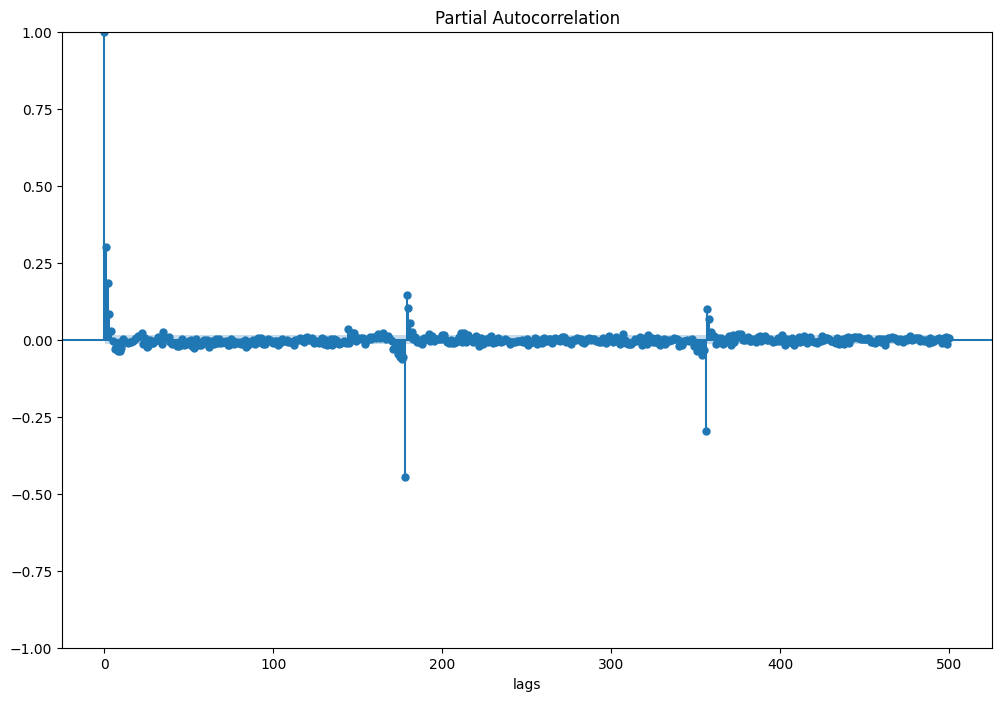

In [ ]:
# Removing seasonality
ax_diff = df["Ax"].diff(peaks[0]).dropna()

plot_acf(ax_diff, lags=500)
plot_pacf(ax_diff, lags=500)
plt.xlabel('lags')
plt.show()

## ACF and PACF for model fitting

We have now applied seasonal differencing only, since there was no need for trend differencing. At this point, we take a look back at lower lags of the ACF and PACF.

Remember the rule of thumb:

* If ACF tails off, and PACF cuts off after a certain lag p: AR(p) model.
* If ACF cuts off after a certain lag q, and PACF tails off: MA(q) model.
* If both ACF and PACF tail off: ARMA model.

What model would you choose from the following plot?

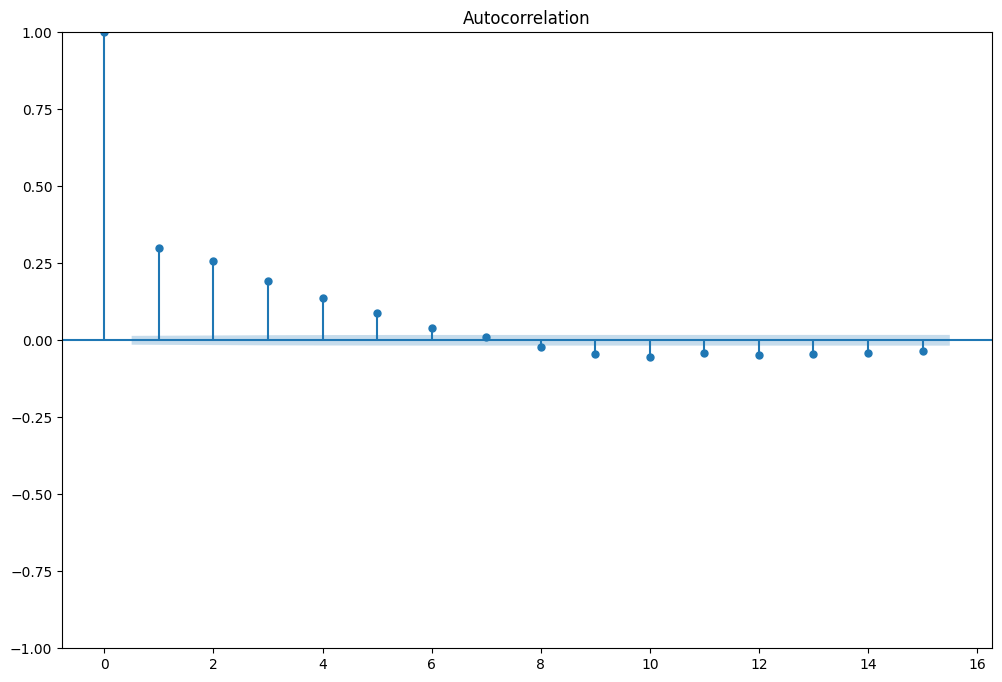

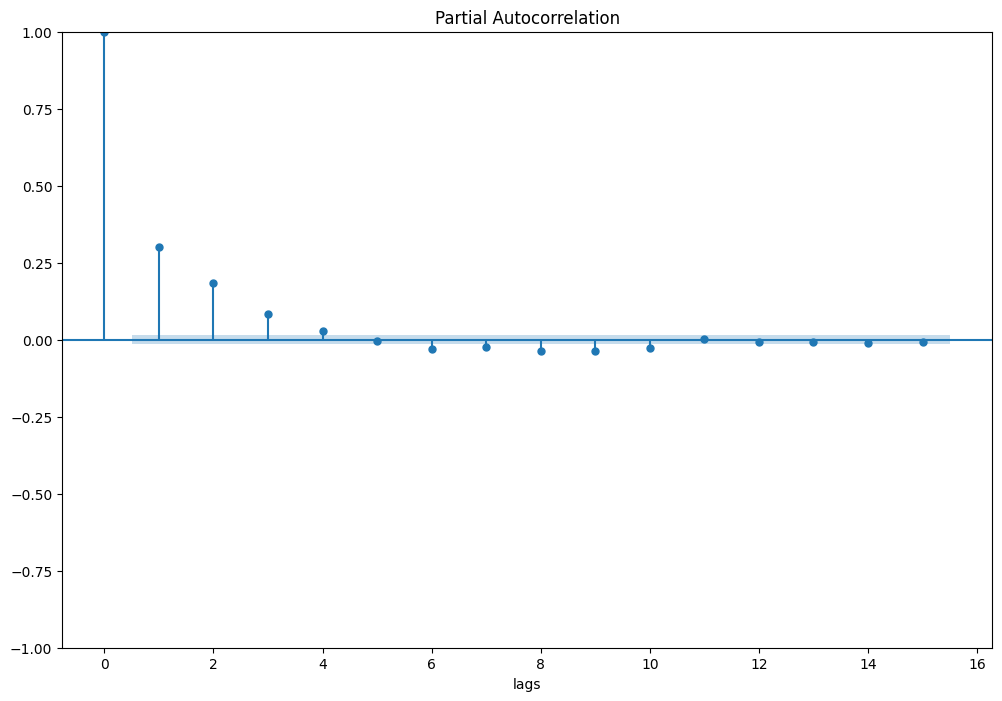

In [ ]:
plot_acf(ax_diff, lags=15)
plot_pacf(ax_diff, lags=15)
plt.xlabel('lags')
plt.show()

## Model fitting

Fitting an ARMA model requires extensive exploration of the parameter space.

This operation may require some time.

In the meanwhile:

* What can we say about model order and differencing?
* What can we say about the Akaike coefficient and its interpretation?

In [ ]:
p = q = range(1, 4)
performance = {}

pq = itertools.product(p, q)
for param in pq:
    try:
        model = ARIMA(ax_diff, order=(param[0], 0, param[1]))
        results = model.fit()
        print('ARMA{} - AIC:{}'.format(param, results.aic))
        performance[param] = results.aic
    except:
        continue

ARMA(1, 1) - AIC:59737.01791457405
ARMA(1, 2) - AIC:59687.86919017961
ARMA(1, 3) - AIC:59676.0704221558
ARMA(2, 1) - AIC:59693.7060621544
ARMA(2, 2) - AIC:59600.813209139524
ARMA(2, 3) - AIC:59601.3804419788
ARMA(3, 1) - AIC:59686.29826048625
ARMA(3, 2) - AIC:59601.3348451
ARMA(3, 3) - AIC:59604.80712874019


In [ ]:
best_performance = dict(sorted(performance.items(), key=lambda x: x[1]))

for param, aic in best_performance.items():
  print('ARMA{} - AIC:{}'.format(param, aic))

ARMA(2, 2) - AIC:59600.813209139524
ARMA(3, 2) - AIC:59601.3348451
ARMA(2, 3) - AIC:59601.3804419788
ARMA(3, 3) - AIC:59604.80712874019
ARMA(1, 3) - AIC:59676.0704221558
ARMA(3, 1) - AIC:59686.29826048625
ARMA(1, 2) - AIC:59687.86919017961
ARMA(2, 1) - AIC:59693.7060621544
ARMA(1, 1) - AIC:59737.01791457405


## Fit again the best model

In [ ]:
model = ARIMA(ax_diff, order=(next(iter(best_performance))[0], 0, next(iter(best_performance))[1]))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     Ax   No. Observations:                18532
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -29794.407
Date:                Mon, 08 May 2023   AIC                          59600.813
Time:                        13:10:31   BIC                          59647.777
Sample:                             0   HQIC                         59616.235
                              - 18532                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.251e-06      0.015      0.000      1.000      -0.029       0.029
ar.L1          1.6534      0.024     68.080      0.000       1.606       1.701
ar.L2         -0.7318      0.018    -40.468      0.000      -0.767      -0.696
ma.L1         -1.4278      0.024    -58.396      0.000      -1.476      -1.380
ma.L2          0.5580      0.014     39.879      0.000       0.531       0.585
sigma2         1.4587      0.010    144.745      0.000       1.439       1.478
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):              4983.34
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.05
Prob(H) (two-sided):                  0.31   Kurtosis:                         5.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The `plot_diagnostics()` method is a function provided by the `statsmodels` Python library that allows you to visualize the performance of a model by examining the residuals (the difference between the actual values and the predicted values) of the model.

The four plots generated by `plot_diagnostics()` are as follows:

1. **Standardized residuals plot**: This plot displays the standardized residuals of the model on the y-axis and the predicted values on the x-axis. Standardized residuals are the residuals divided by their standard deviation. This plot is useful for checking the assumption that the residuals should have a mean of zero and constant variance. If the residuals are not randomly scattered around zero and there is a visible pattern in the plot (e.g., a curved line or a cone shape), this could indicate that the model is not capturing some important relationship in the data.

2. **Histograms plus estimated density plot**: This plot displays the histogram of the residuals (in blue) as well as a density estimate of the residuals (in red). This plot is useful for checking the assumption that the residuals should be normally distributed. If the residuals are normally distributed, the histogram should resemble a bell-shaped curve.

3. **Normal Q-Q plot**: This plot displays the quantiles of the standardized residuals on the y-axis and the theoretical quantiles of a normal distribution on the x-axis. This plot is useful for checking the assumption that the residuals should be normally distributed. If the residuals are normally distributed, the points in the plot should fall close to a straight line.

4. **Correlogram plot**: This plot displays the autocorrelation of the residuals at different lags. This plot is useful for checking the assumption that the residuals should be uncorrelated with each other. If there is significant autocorrelation (i.e., if the bars in the plot extend beyond the dashed blue lines), this could indicate that the model is not capturing some important time-series dependence in the data.

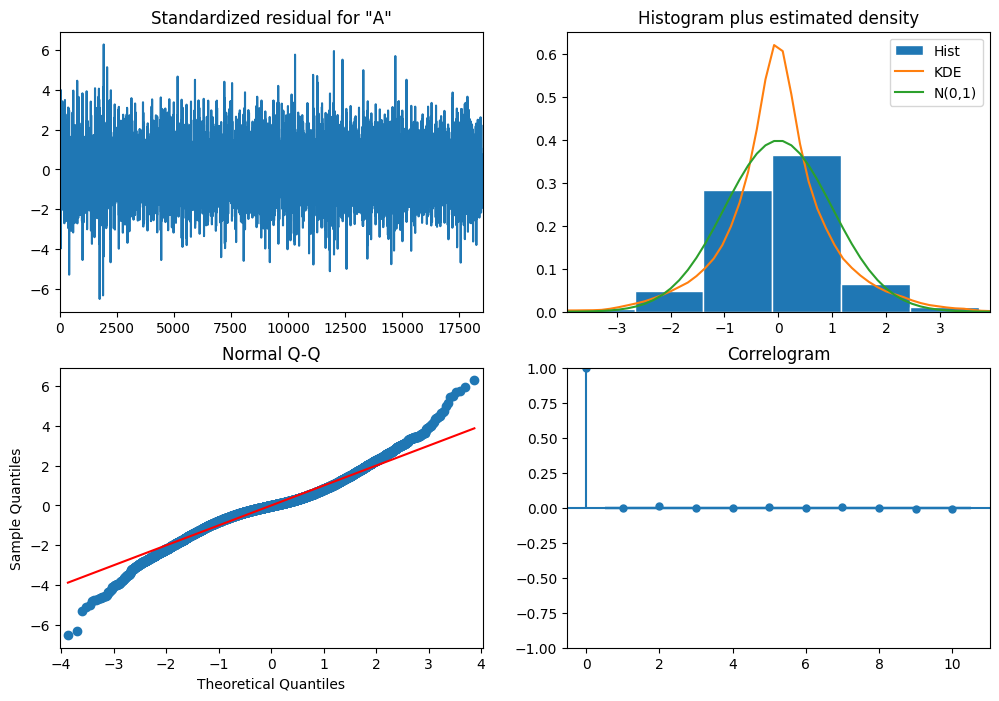

In [ ]:
results.plot_diagnostics()
plt.show()

## One-step-ahead predictions

Let's generate the one step ahead predictions on the training data.

In [ ]:
# Generate predictions
one_step_forecast = results.get_prediction()

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Ax']
upper_limits = confidence_intervals.loc[:,'upper Ax']

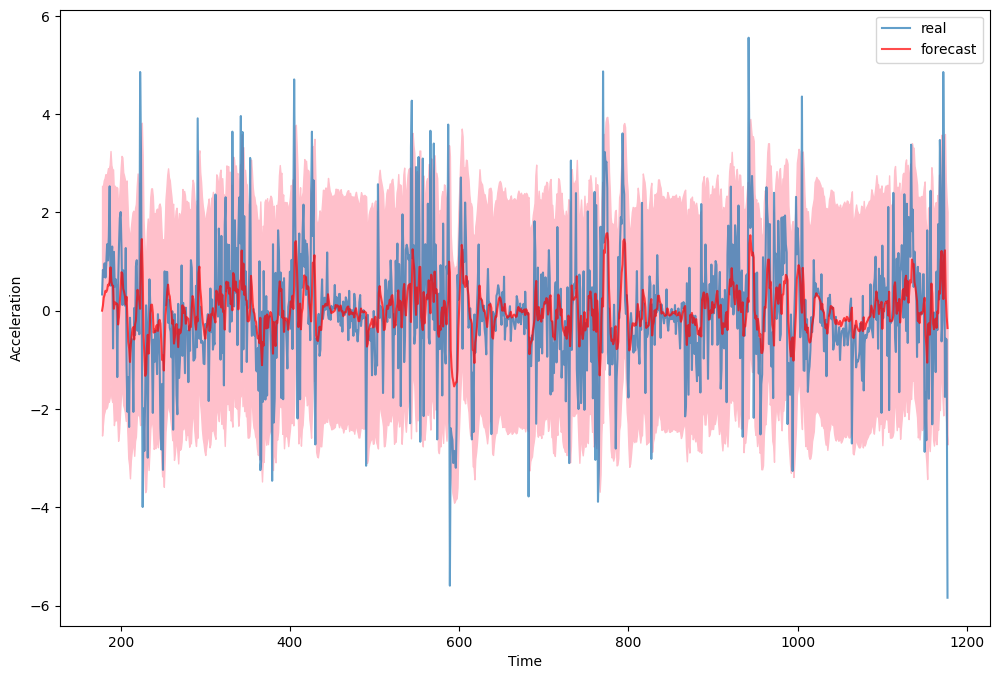

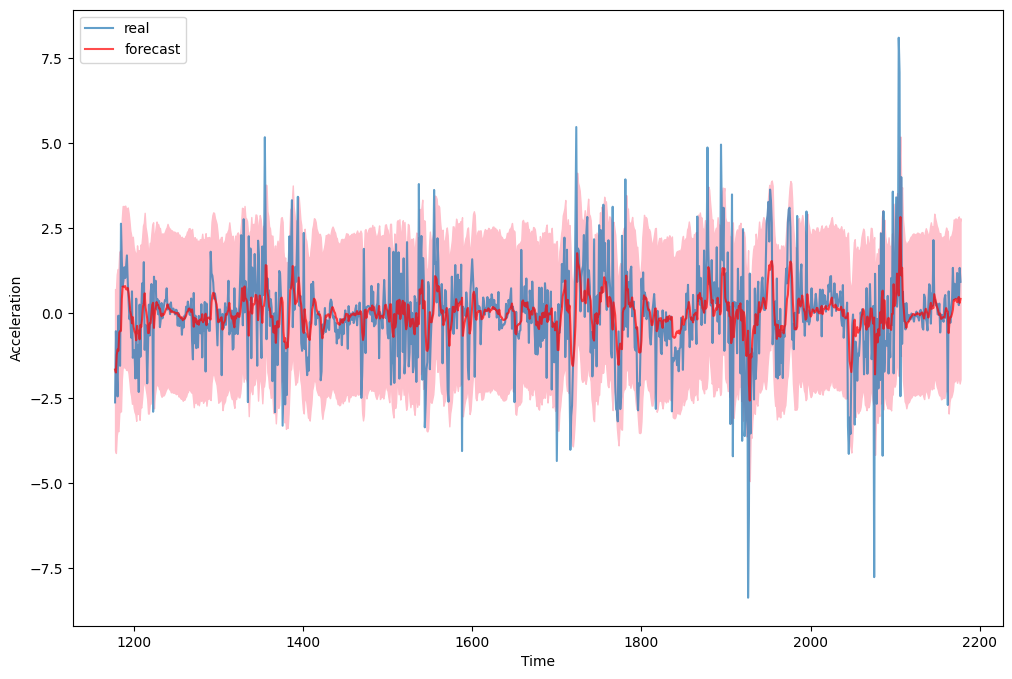

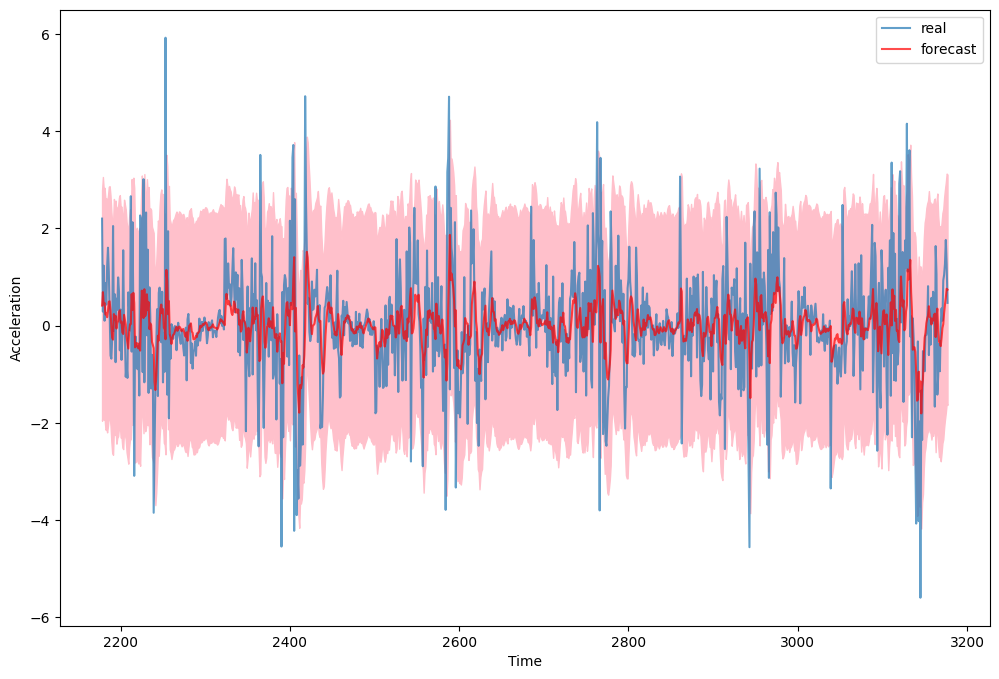

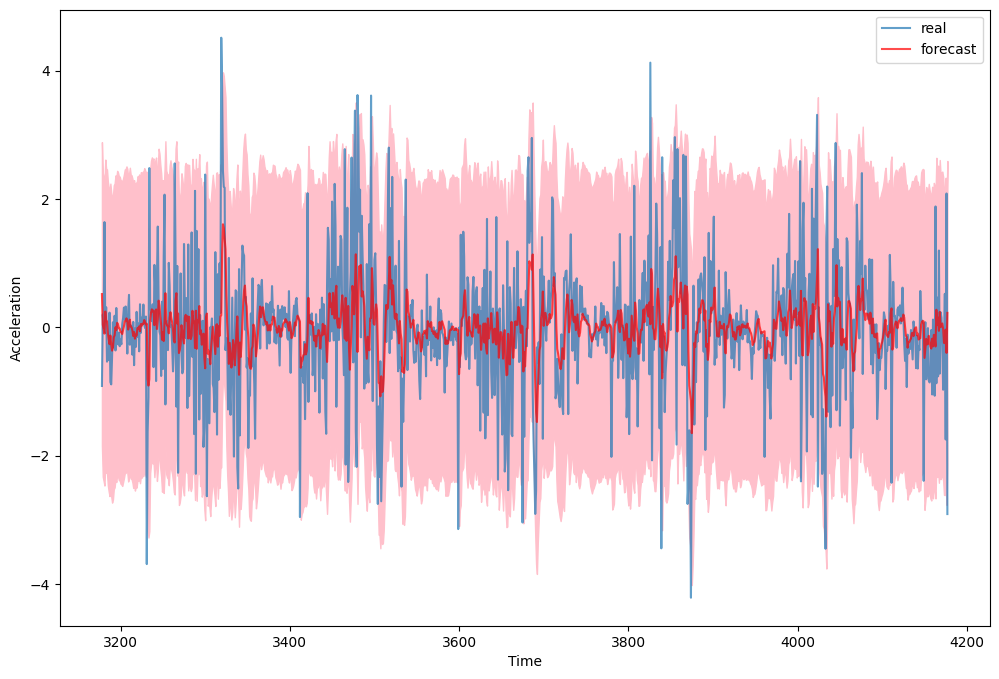

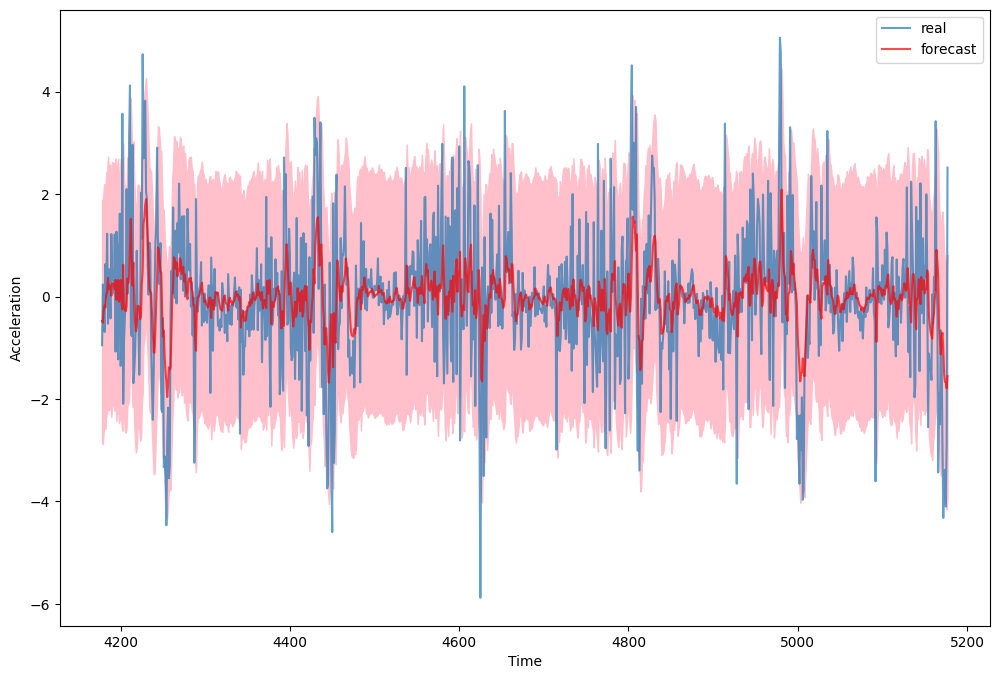

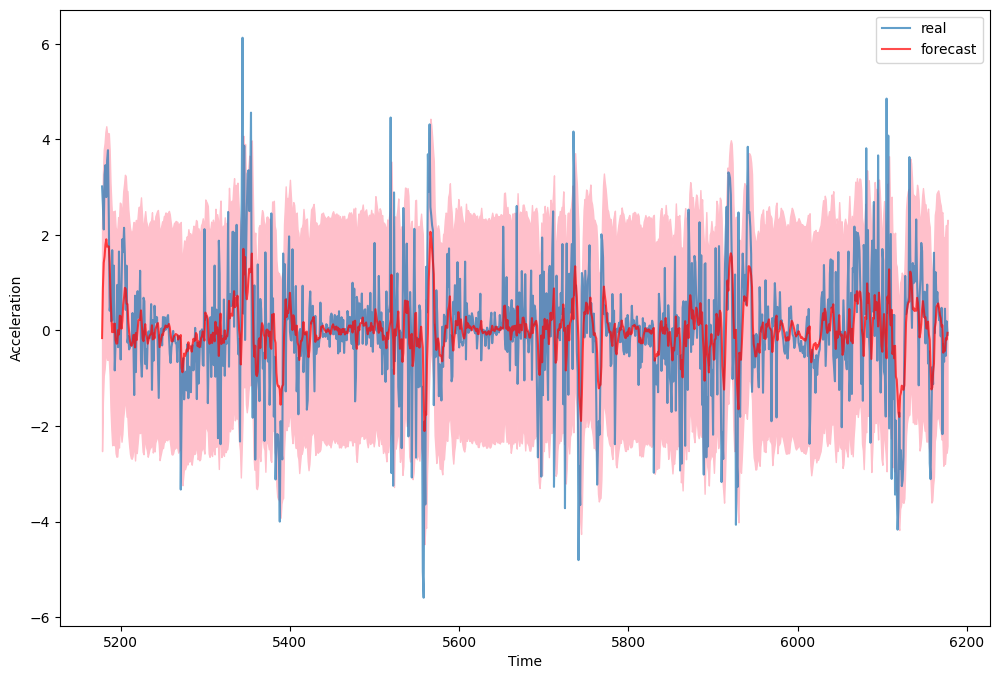

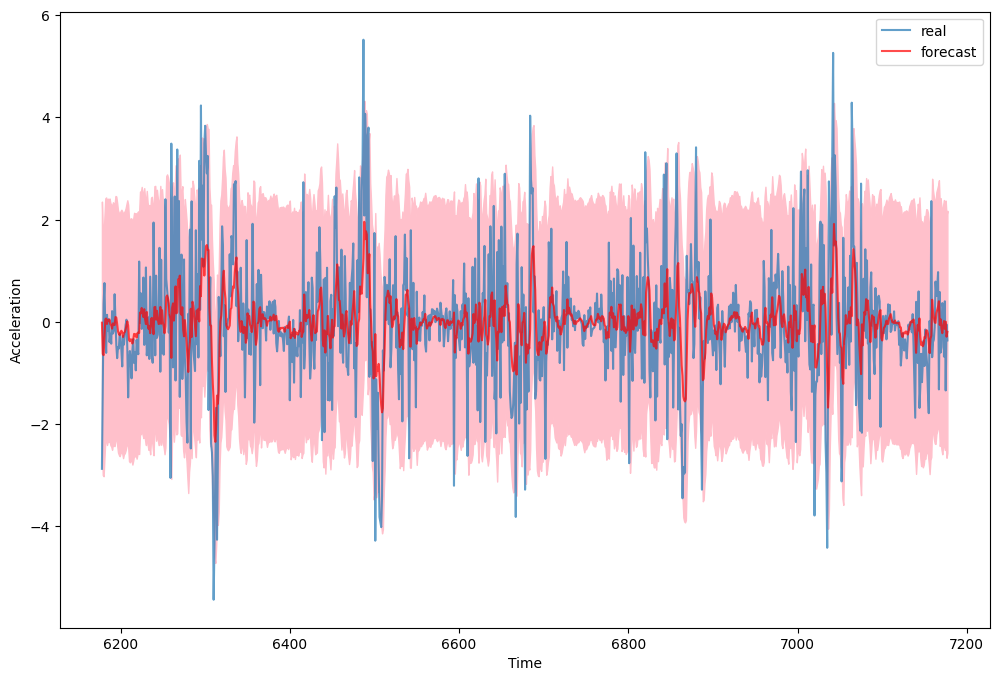

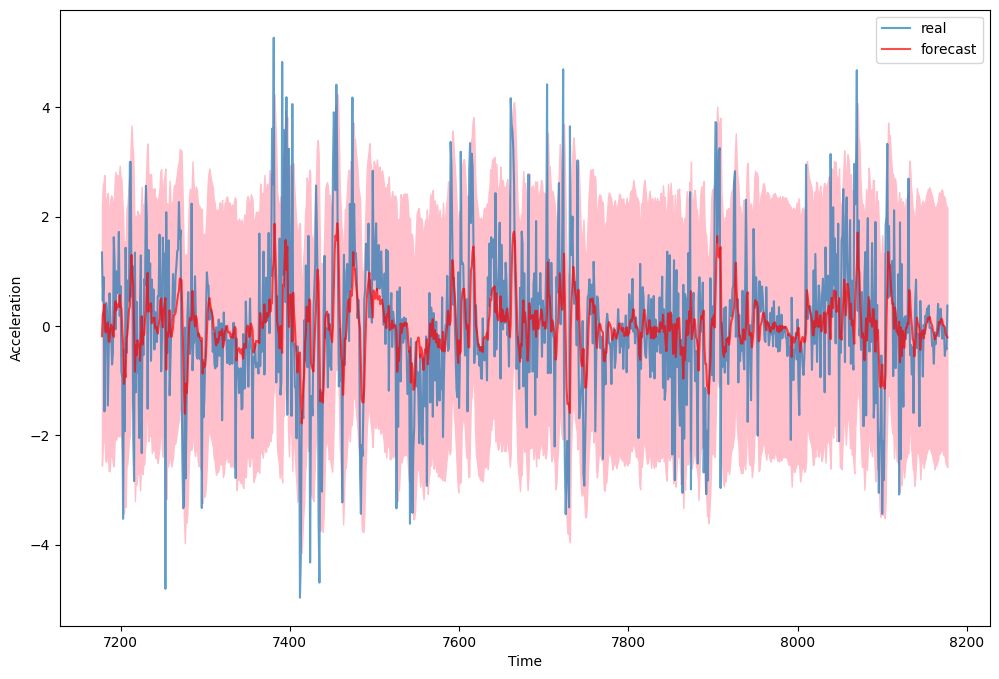

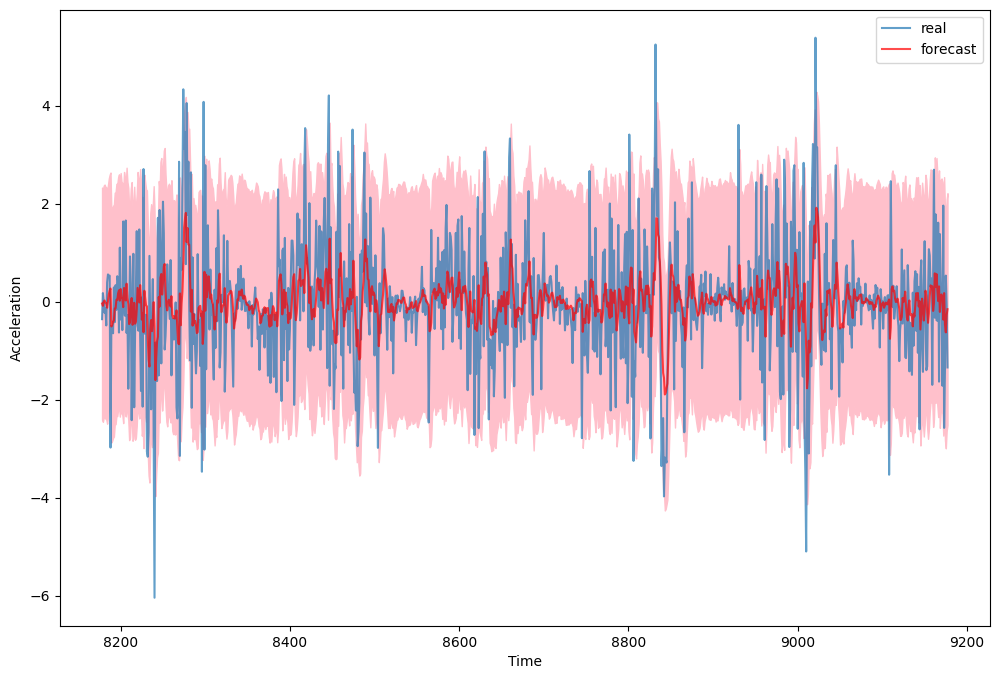

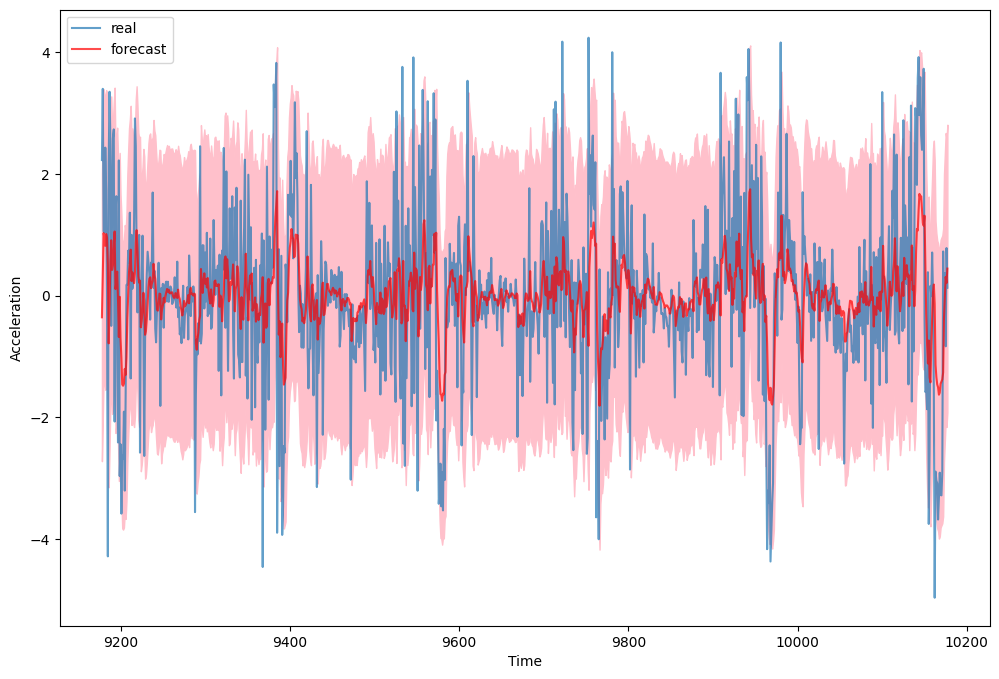

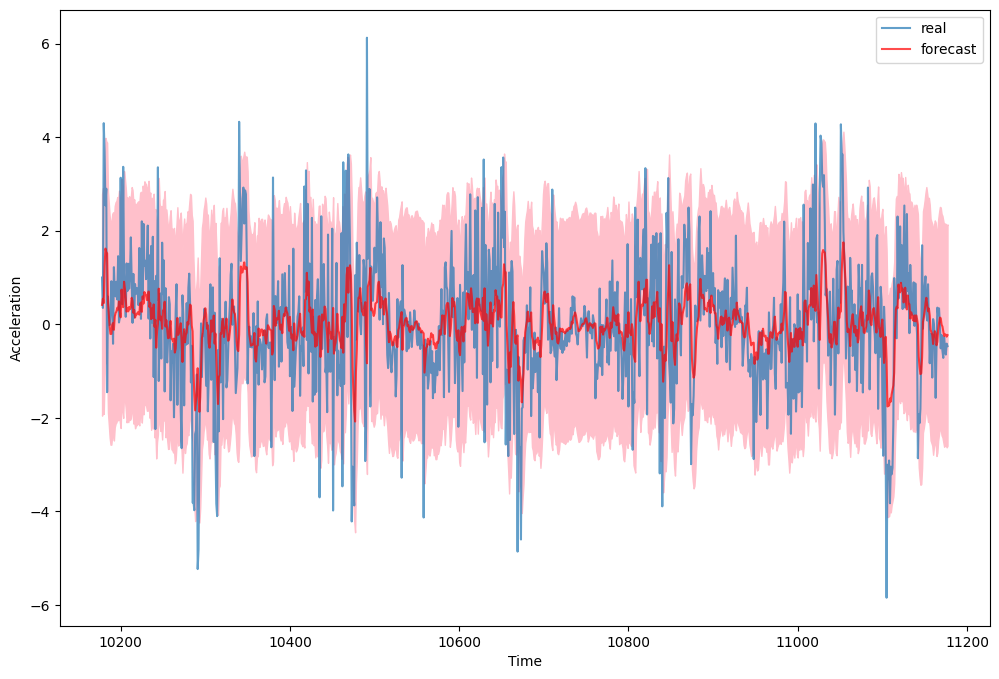

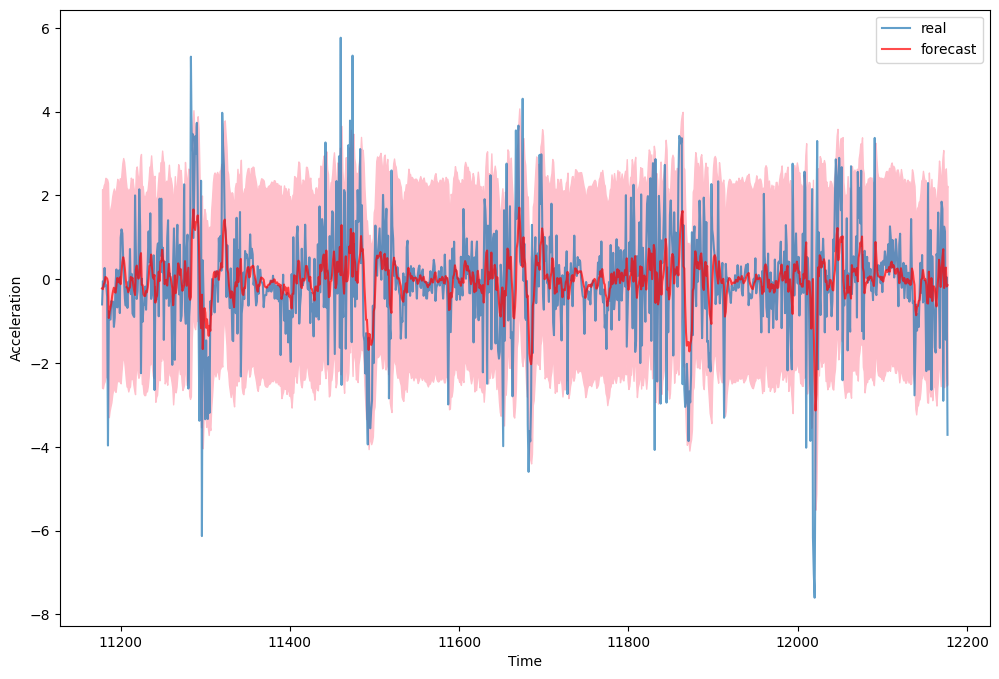

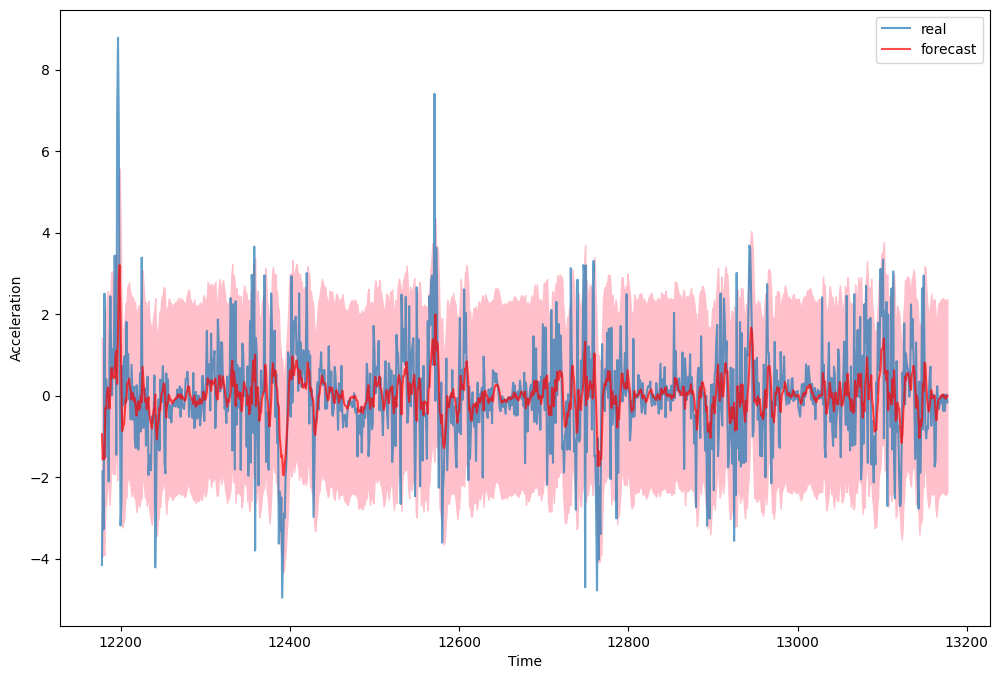

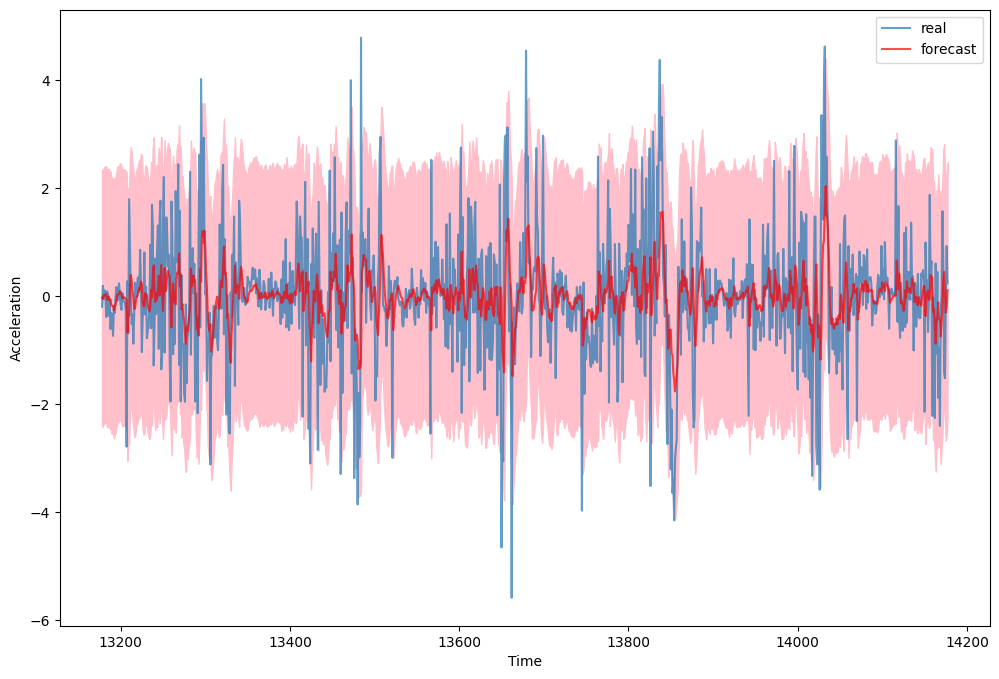

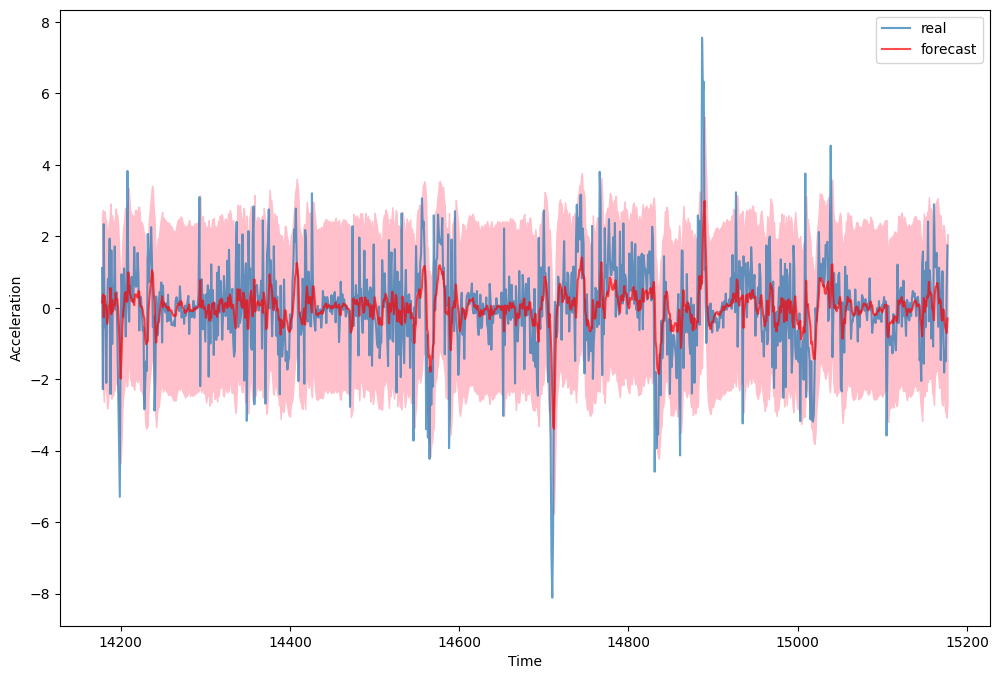

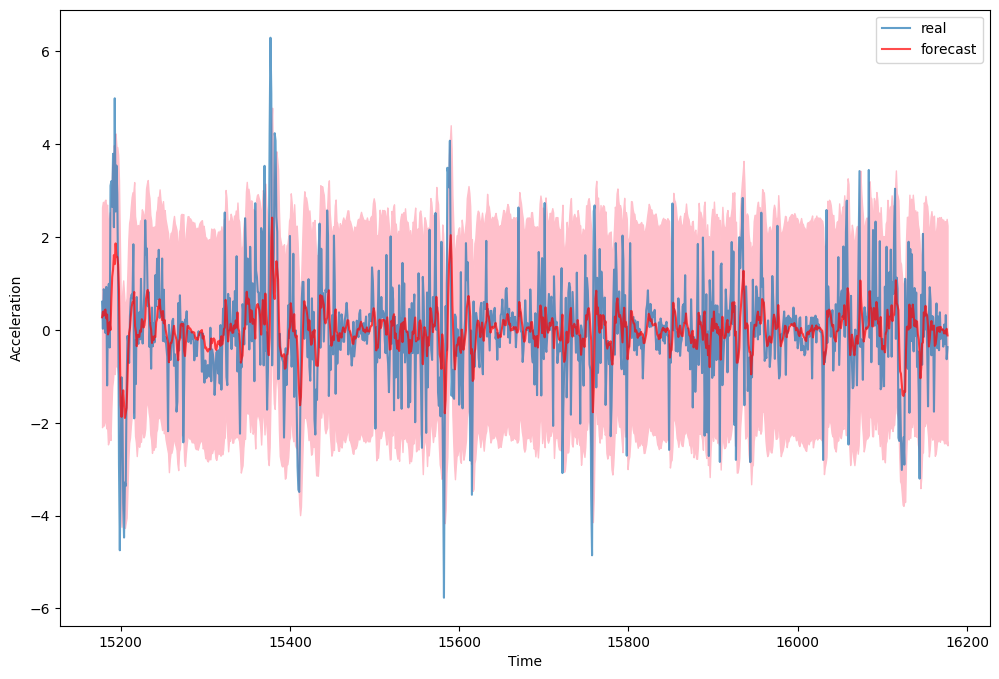

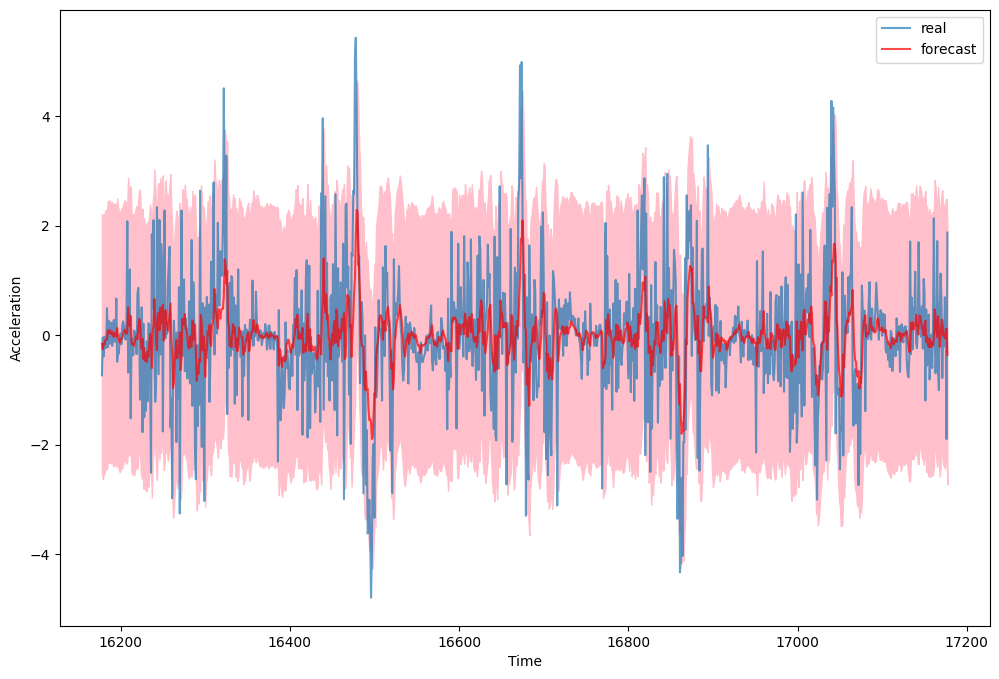

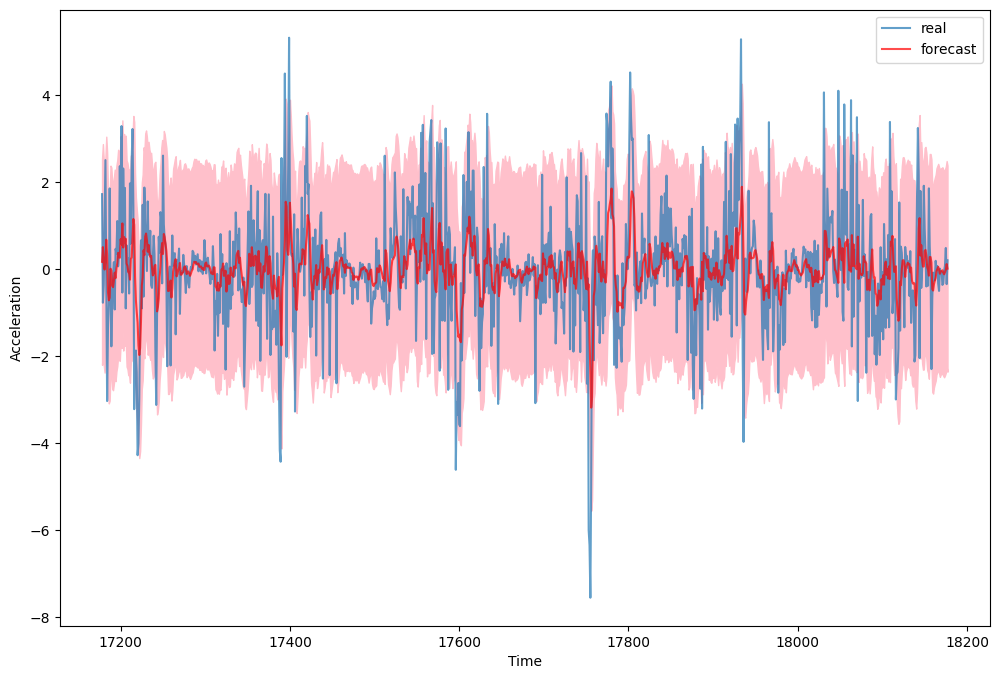

In [ ]:
for i in range(0, len(df) - 1000, 1000):
    start = i
    end = i + 1000
    
    # plot the real data
    plt.plot(ax_diff.index[start:end], ax_diff[start:end], label='real', alpha=0.7)

    # plot your mean predictions
    plt.plot(mean_forecast.index[start:end], mean_forecast[start:end], color='r', 
             label='forecast', alpha=0.7)

    # shade the area between your confidence limits
    plt.fill_between(lower_limits.index[start:end], lower_limits[start:end],
                     upper_limits[start:end], color='pink')

    # set labels, legends and show plot
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.legend()
    plt.show()

## Numerical performance

The are several way to assess model's performance, among them: MSE and R2 coefficient.

$MSE = \frac{1}{n} \sum_{i=1}^n (y_i - \bar{y})^2$

where $n$ is the number of data points, $y_i$ is the actual value of the i-th data point, $\bar{y}$ is the mean of all actual values.

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$

$SS_{res} = \sum_{i=1}^n (y_i - \bar{y})^2$

$SS_{tot} = \sum_{i=1}^n (y_i - \hat{y})^2$

where $SS_{res}$ is the sum of squared residuals, which is the sum of the squares of the differences between the predicted and actual values, $SS_{tot}$ is the total sum of squares, which is the sum of the squares of the differences between the actual values and the mean of the values.

In [ ]:
# generate predictions
pred = results.get_prediction().predicted_mean

# compute mean squared error and R2 coefficient
mse = mean_squared_error(ax_diff, pred)
r2 = r2_score(ax_diff, pred)

print(f"Best ARMA model:\nMSE: {mse:.3}\nR2: {r2:.3}")

Best ARMA model:
MSE: 1.46
R2: 0.132


# Activity 4: Machine Learning models training and evaluation for autoregression

We will train from scratch a machine learning autoregressor. This time, we will not enter the details of the preprocessing steps, which will be addressed in the future laboratory days.

## Data preparation

With deep neural network, we can perform both **univariate** **and** **multivariate autoregression**. Namely, we can use the axial acceleration over X axis `Ax` or also the axial acceleration over Y axis `Ay` and angular acceleration `Gz` to predict the next value of `Ax`.

#### Univariate data

In [ ]:
def prepare_univariate_data(ts, n):
    """
    Prepare dataset for autoregression task.
    
    Args:
        ts (numpy.ndarray): Univariate time series.
        n (int): Window size for each data point.
    
    Returns:
        Tuple containing X, y.
    """

    ts = ts.to_numpy()

    X, y = [], []
    for i in range(n, len(ts)):
        X.append(ts[i-n:i])
        y.append(ts[i])
    X, y = np.array(X), np.array(y)
    
    return X, y

In [ ]:
# Prepare data with window size 10
X_univ, y_univ = prepare_univariate_data(df["Ax"], n=10)

input_size_univariate = X_univ.shape[1]

# Print the shapes of the data
print(X_univ.shape, y_univ.shape)

(18700, 10) (18700,)


#### Multivariate data

In [ ]:
def prepare_multivariate_data(df, n, autoregressive_column="Ax"):
    """
    Prepare dataset for autoregression task with multivariate time series.
    
    Args:
        df (pandas.DataFrame): Multivariate time series dataframe.
        n (int): Window size for each data point.
    
    Returns:
        Tuple containing X, y.
    """
    
    X, y = [], []
    for i in range(n, len(df)):
        X.append(df.iloc[i-n:i].values)
        y.append(df[autoregressive_column].iloc[i])
    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
    
    return X, y

In [ ]:
# Prepare data with window size 10
X_mult, y_mult = prepare_multivariate_data(df, n=10)

input_size_multivariate = X_mult.shape[1] 

# Print the shapes of the data
print(X_mult.shape, y_mult.shape)

(18700, 30) (18700,)


## Machine learning utility functions

We define the following functions to create the neural network and plot its training metrics.

In [ ]:
def build_regressor(input_size, hidden, activation='relu'):
    input_shape = (input_size,)
    model_in = keras.Input(shape=input_shape, dtype='float32')
    x = model_in
    for h in hidden:
        x = layers.Dense(h, activation=activation)(x)
    model_out = layers.Dense(1, activation='linear')(x)
    model = keras.Model(model_in, model_out)
    return model

In [ ]:
# Plot train loss and validation loss
def plot_loss(history, name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    plt.title(name)
    plt.show()

## Model definition - Univariate case

Here we build the model and compile it, meaning we assign to it an optimizer and a loss function.

The optimizer has the scope to perform the backpropagation step in order to decrease the model's error (i.e., minimize the loss).

* Can you identify which are the parameters shown through the `summary` method?

In [ ]:
nn = build_regressor(input_size=input_size_univariate, 
                     hidden=[64, 32], 
                     activation="relu") 
nn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')
nn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________


## Training

The training consists in several feedforward pass of the data and feedback pass of the weights' gradients through the neural network.

This phase allows to optimize the neural network right to the task we have defined.

* Do you recognize all the parameters passed to the `fit` method?

In [ ]:
cb = [callbacks.EarlyStopping(patience=20, restore_best_weights=True)]
history_nn = nn.fit(X_univ, y_univ, validation_split=0.2,
                    callbacks=cb, batch_size=32, epochs=150, verbose=1) 

Epoch 1/150
468/468 [==============================] - 2s 3ms/step - loss: 0.7802 - val_loss: 0.7298
Epoch 2/150
468/468 [==============================] - 1s 2ms/step - loss: 0.7474 - val_loss: 0.7240
Epoch 3/150
468/468 [==============================] - 1s 2ms/step - loss: 0.7382 - val_loss: 0.7264
Epoch 4/150
468/468 [==============================] - 1s 3ms/step - loss: 0.7331 - val_loss: 0.7169
Epoch 5/150
468/468 [==============================] - 1s 3ms/step - loss: 0.7280 - val_loss: 0.7245
Epoch 6/150
468/468 [==============================] - 1s 3ms/step - loss: 0.7232 - val_loss: 0.7225
Epoch 7/150
468/468 [==============================] - 1s 2ms/step - loss: 0.7183 - val_loss: 0.7309
Epoch 8/150
468/468 [==============================] - 1s 2ms/step - loss: 0.7177 - val_loss: 0.7212
Epoch 9/150
468/468 [==============================] - 1s 2ms/step - loss: 0.7164 - val_loss: 0.7308
Epoch 10/150
468/468 [==============================] - 1s 2ms/step - loss: 0.7089 - val_lo

## Numerical performance

Here we plot the loss of the training and we print out the MSE and R2 coefficient. 

What are the main take away we can derive? How is the model performing?

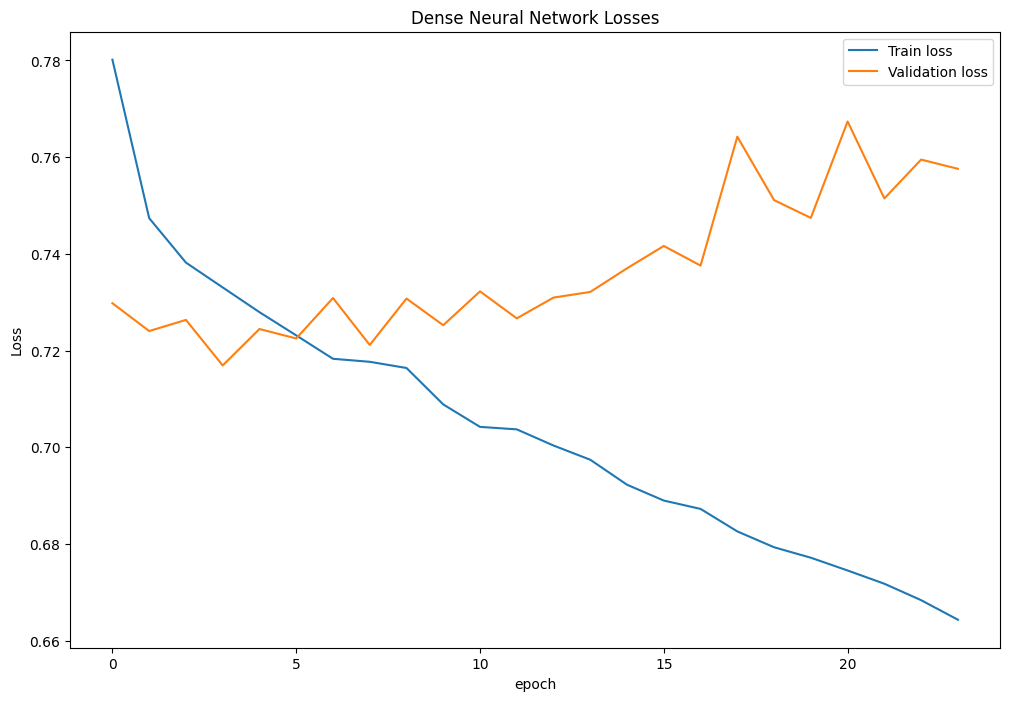

In [ ]:
plot_loss(history_nn, "Dense Neural Network Losses")

In [ ]:
pred = nn.predict(X_univ)

# compute mean squared error and R2 coefficient
mse = mean_squared_error(y_univ, pred)
r2 = r2_score(y_univ, pred)

print(f"Neural network model:\nMSE: {mse:.3}\nR2: {r2:.3}")

585/585 [==============================] - 1s 1ms/step
Neural network model:
MSE: 0.719
R2: 0.281


## Exercises

#### Develop a neural network to perform multivariate autoregression

You are now ready to make a step further: try to write with our help the next code cells to train a multivariate neural network for autoregression of `Ax`.

The data are already available in `X_mult` and `y_mult`.

Try to:
1. Build a dense neural network in Keras, with parameters of your choice
2. Compile the neural network
3. Train the neural network
4. Plot the loss
5. Evaluate the results

Does the performance improve?

In [ ]:
# Develop you code here, you may also create other code cells

#### Change the window size for multivariate data

Try now to increase or decrease the window size (parameter `n` in `prepare_multivariate_data`). 

Develop again a neural network with the new data. 

How does this change affect the performance?

In [ ]:
# Develop you code here, you may also create other code cells

#### Change the autoregressive column

Try now to change the autoregressive column to `Gz` (parameter `autoregressive_column` in `prepare_multivariate_data`). 

Develop again a neural network with the new data. 

Is this task simpler or harder? Why?

In [ ]:
# Develop you code here, you may also create other code cells